<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm_univariate_timeseries_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.set_index("Time",inplace=True)
df.index = pd.to_datetime(df.index)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")

df.head()

,vibx,vibz,temp,zacc,crest,zfreq
Time,,,,,,
2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


# Train Test 

In [20]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [21]:
def lstm_anomaly(df,col,date,time_step,threshold):
    print(f"{col}"+50*"*")
    
    
    df1=df[[col]]
    train_size=len(df[df.index < date][col].tolist())
    test_size=df.shape[0]-train_size
    train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df)]
    print(train.shape, test.shape)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])

    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
        
            
    TIME_STEPS = time_step

    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train[[col]], train[col], TIME_STEPS)
    X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)

    print(X_train.shape)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
        
    history = model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,verbose=1
    )
   
    
    X_train_pred = model.predict(X_train)

    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    
    X_test_pred = model.predict(X_test)

    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    
    THRESHOLD = threshold

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
    train_score_df['loss'] = train_mae_loss
    train_score_df['threshold'] = THRESHOLD
    train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
    train_score_df[col] = train[TIME_STEPS:][col]
    
    anomalies_train = train_score_df[train_score_df.anomaly == True]
    
    return anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler

In [22]:
def col_timeseries_plot():
    plt.plot(df[col], label=col)
    plt.xticks(rotation=25)
    plt.legend();

In [23]:
def loss_and_threshold_value_plot():
    plt.plot(test_score_df.index, test_score_df.loss, label='loss_'+col)
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold_'+col)
    plt.xticks(rotation=25)
    plt.legend();

In [24]:
def train_mae_loss():
    sns.distplot(train_mae_loss, bins=50, kde=True);


In [25]:
def anomaly_plot(test,anomalies):
    print(anomalies.head(10))
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.xticks(rotation=25)
    plt.legend();

In [26]:
def loss_plot():
    plt.plot(history.history['loss'], label='train loss_'+col)
    plt.plot(history.history['val_loss'], label='test loss_'+col)
    plt.legend();


In [27]:
total_anomalies = pd.DataFrame()


# vibx 

In [28]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibx",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibx**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 164ms/step - loss: 0.7285 - val_loss: 0.2506
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 0.6128 - val_loss: 0.1876
Epoch 3/500
5/5 [==============================] - 0s 20ms/step - loss: 0.5556 - val_loss: 0.1819
Epoch 4/500
5/5 [==============================] - 0s 18ms/step - loss: 0.5394 - val_loss: 0.1902
Epoch 5/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5325 - val_loss: 0.1882
Epoch 6/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5149 - val_loss: 0.1766
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4943 - val_loss: 0.1769
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4786 - val_loss: 0.1785
Epoch 9/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4693 - val_loss: 0.1847
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4535 - val_loss: 0.1755
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


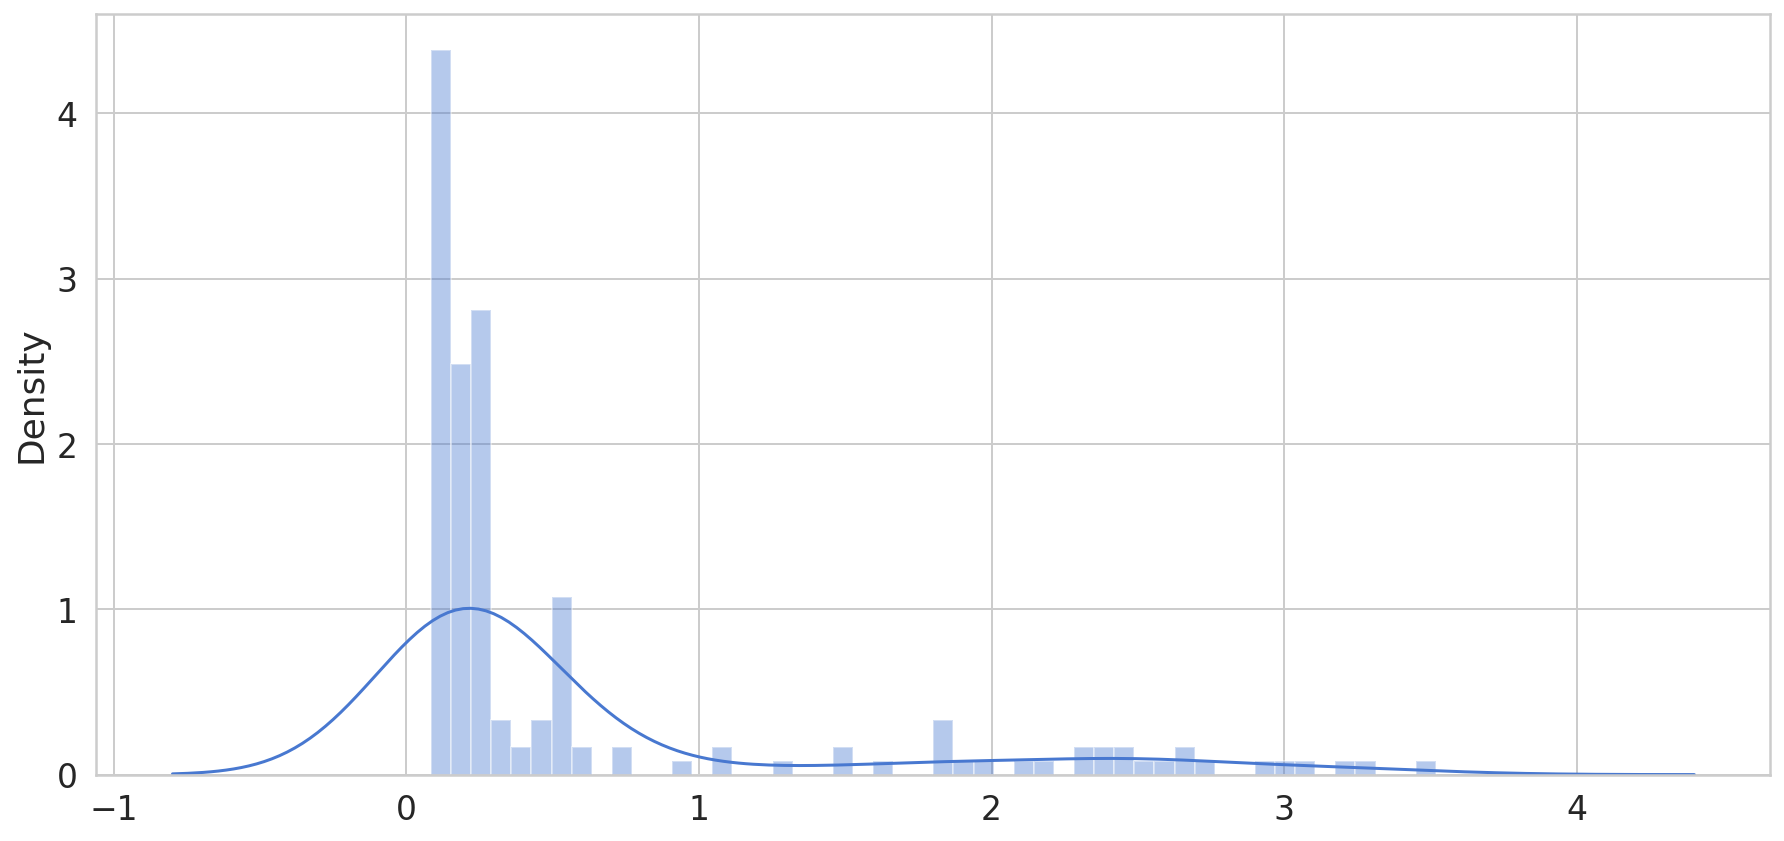

In [29]:
sns.distplot(train_mae_loss, bins=50, kde=True)

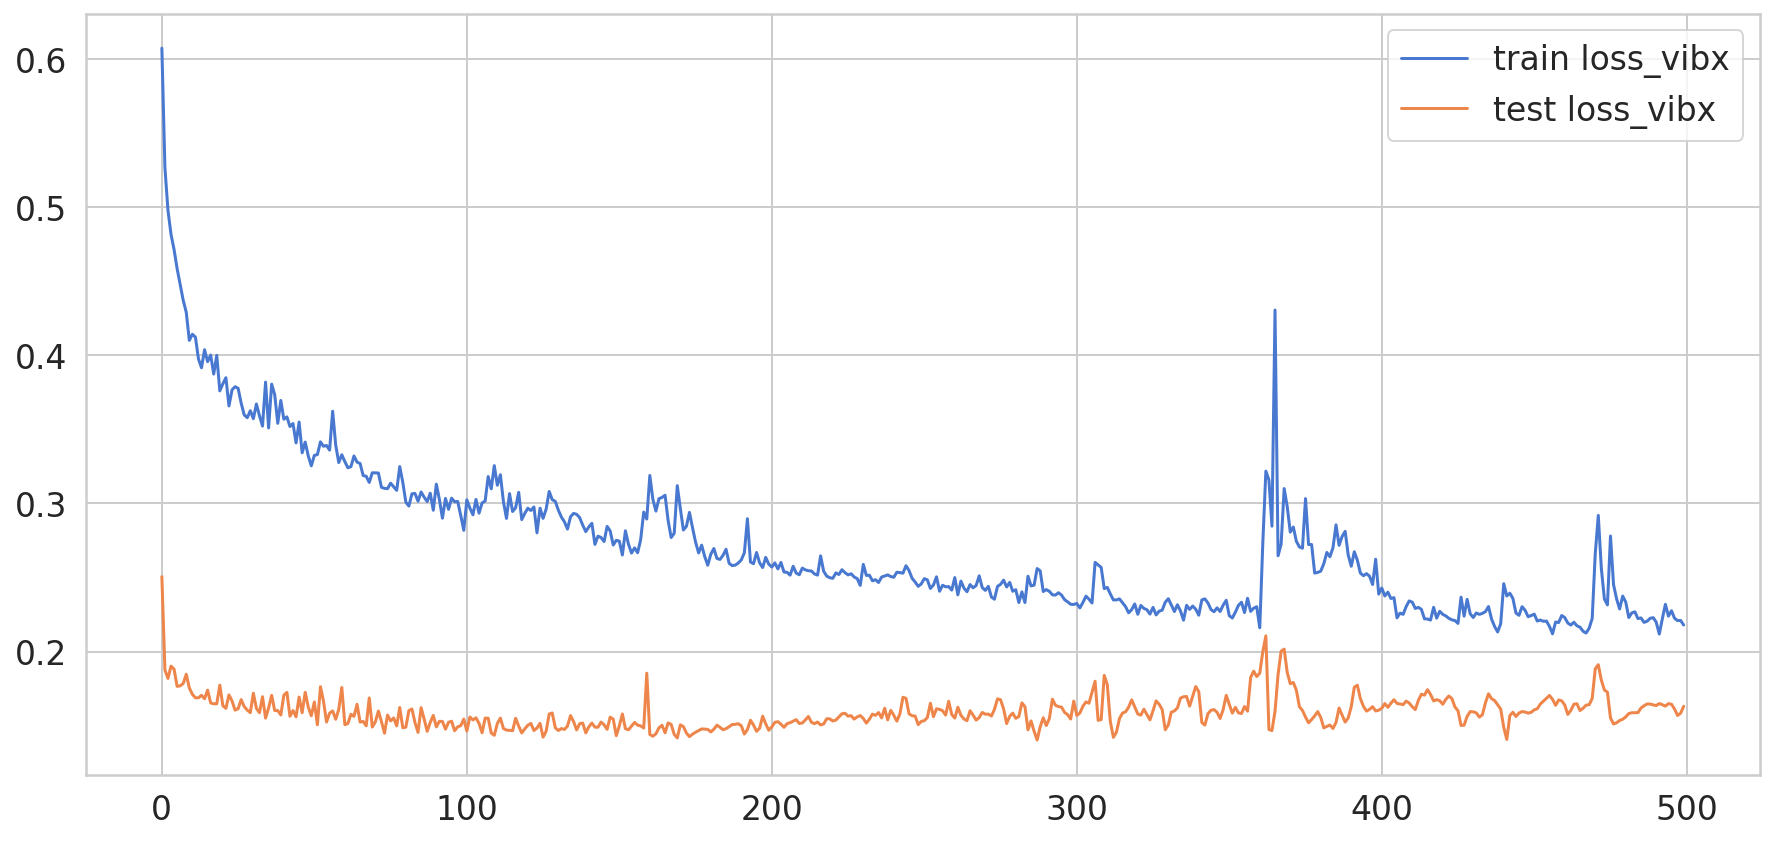

In [30]:
loss_plot()

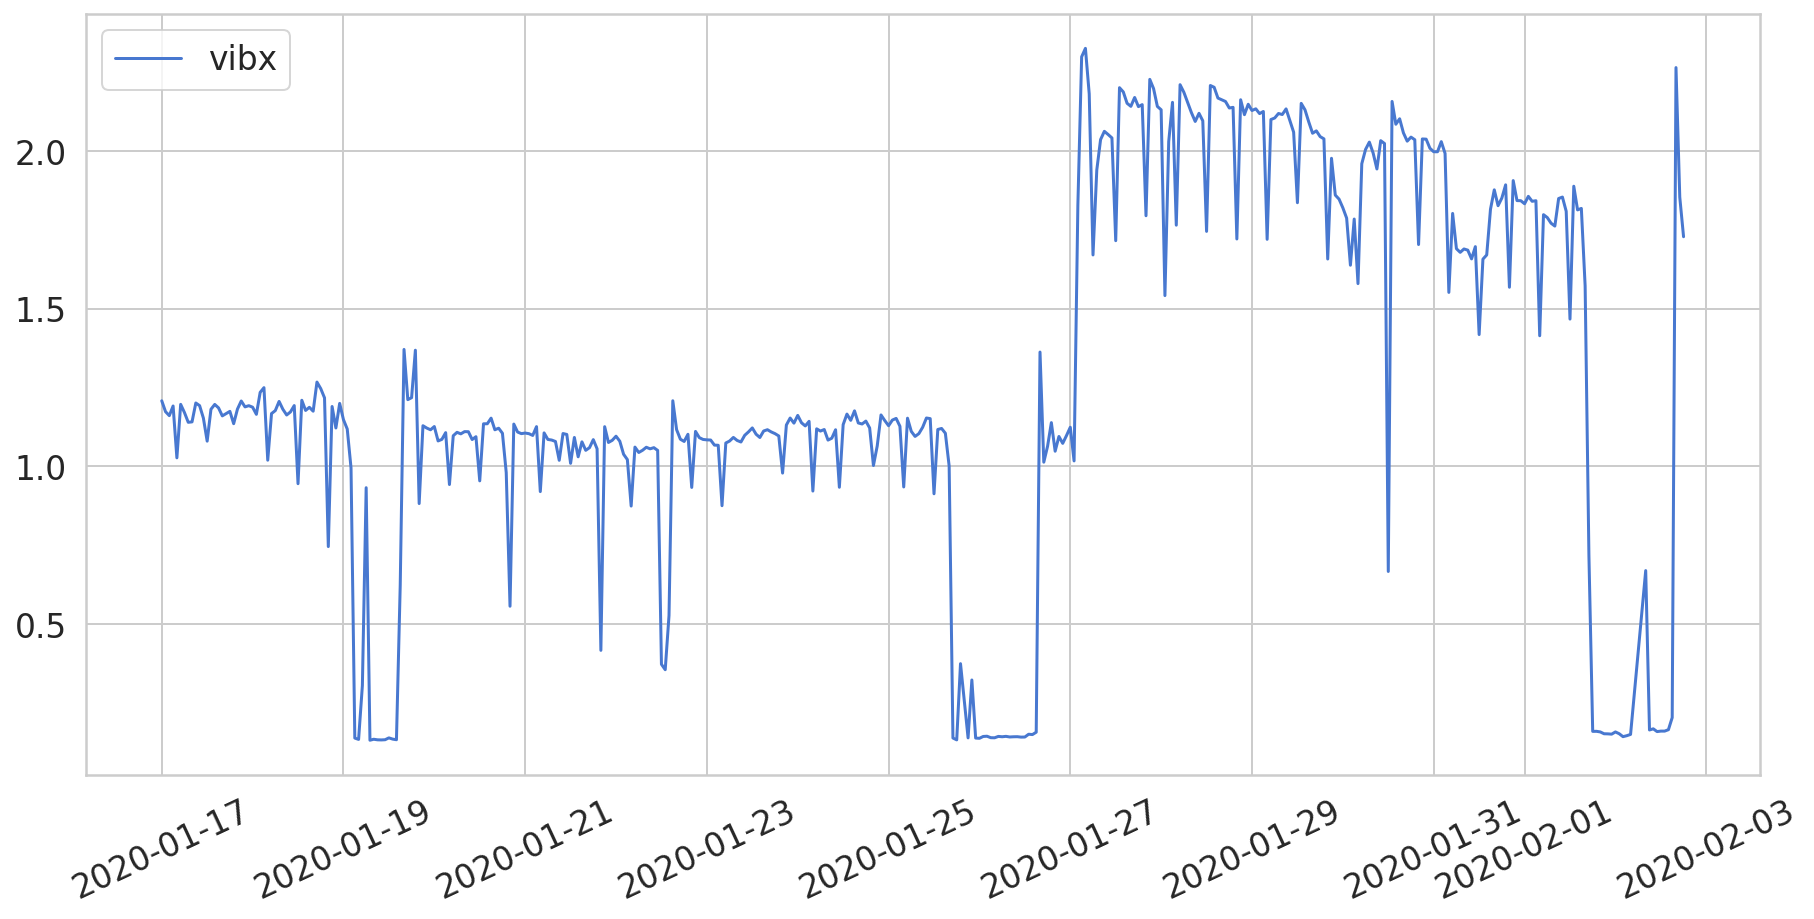

In [31]:
col_timeseries_plot()

                         loss  threshold  anomaly      vibx
Time                                                       
2020-01-26 17:00:00  3.869471        3.1     True -0.091629
2020-01-26 18:00:00  3.879809        3.1     True  0.106375
2020-01-26 19:00:00  3.664081        3.1     True  0.399538
2020-01-26 20:00:00  3.264863        3.1     True  0.044636
2020-01-27 19:00:00  3.117374        3.1     True  4.348415
2020-01-27 20:00:00  3.305094        3.1     True  2.968561
2020-01-27 21:00:00  3.439499        3.1     True  4.662030
2020-01-27 22:00:00  3.608347        3.1     True  4.547369
2020-01-27 23:00:00  3.691802        3.1     True  4.326195
2020-01-28 00:00:00  3.660717        3.1     True  4.284419


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


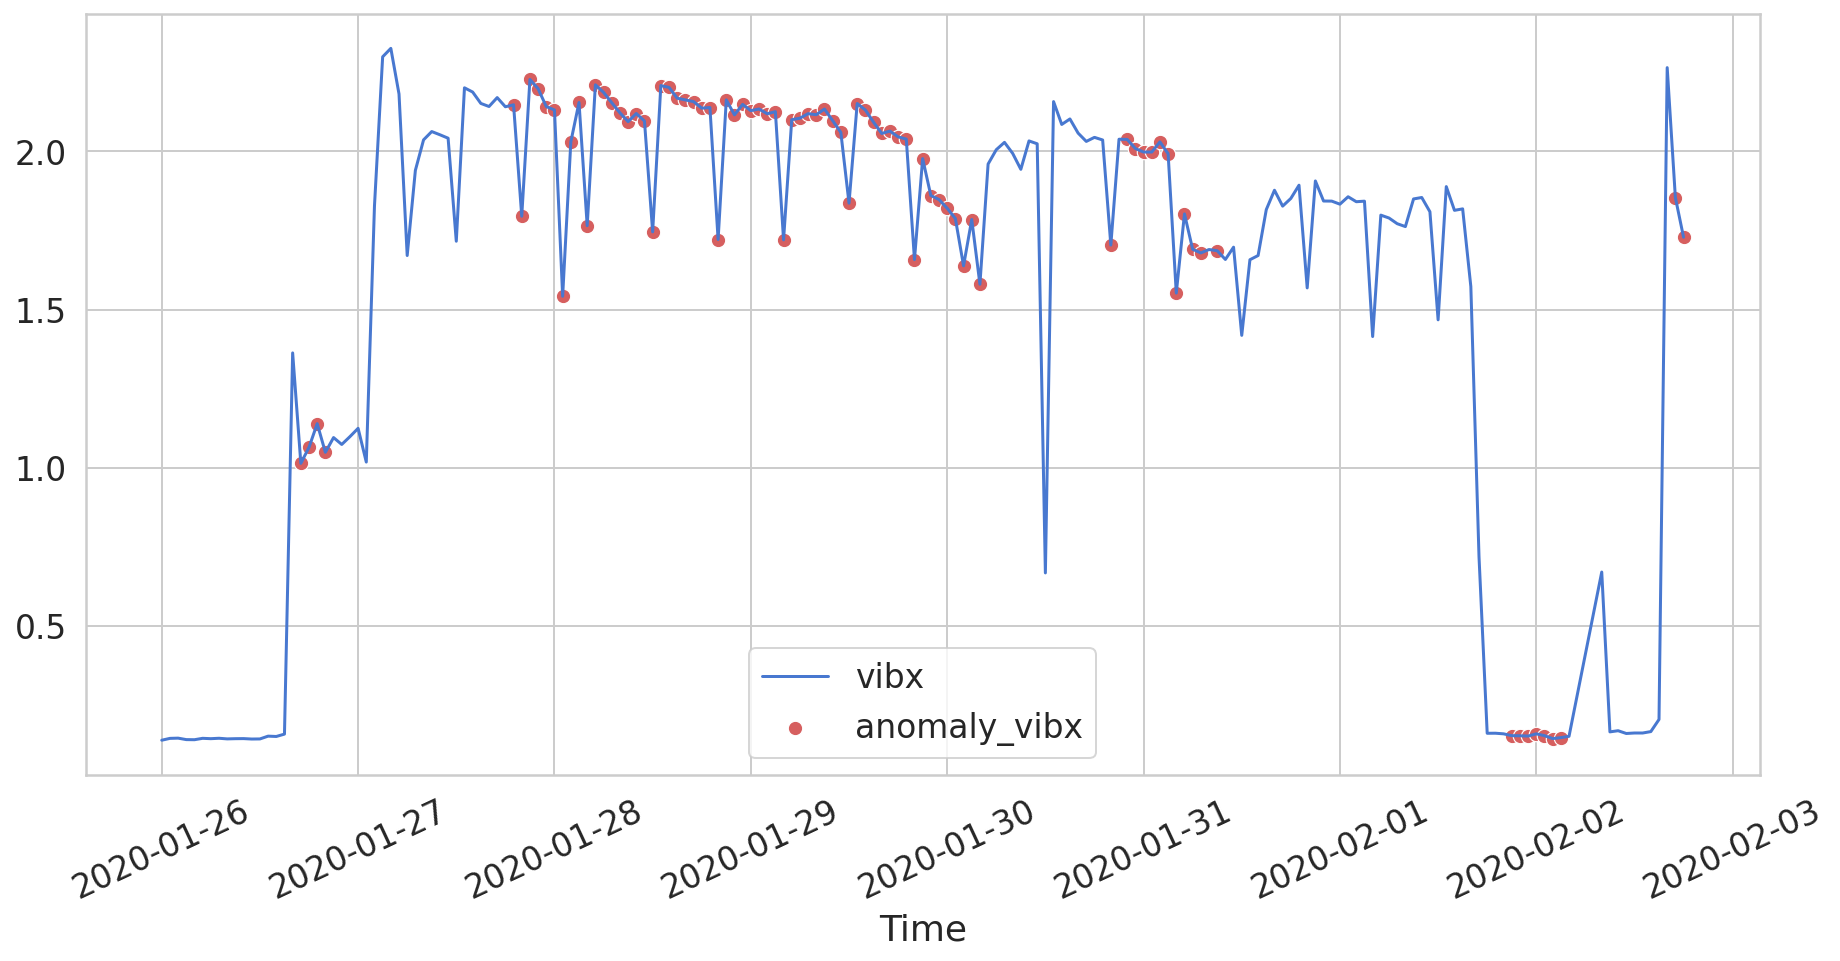

In [32]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly      vibx
Time                                                       
2020-01-19 04:00:00  3.518522        3.1     True -3.534243
2020-01-19 07:00:00  3.264921        3.1     True -3.544290
2020-01-19 16:00:00  3.199906        3.1     True  1.308521


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


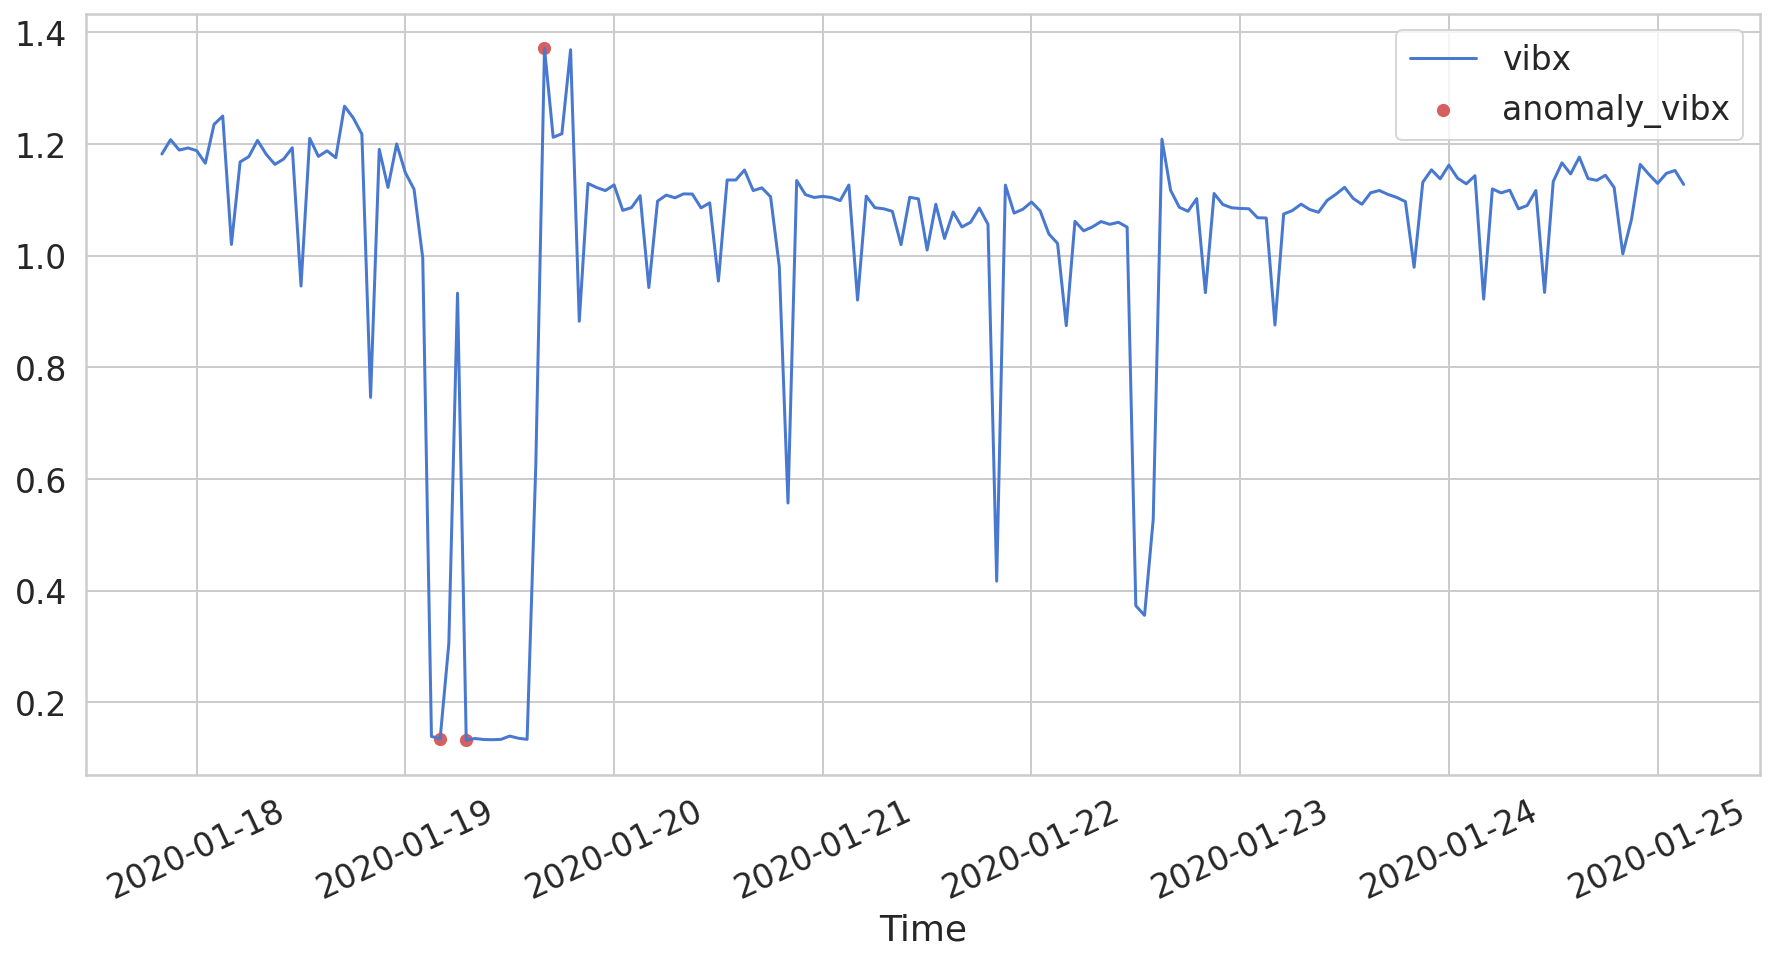

In [33]:
anomaly_plot(train,anomalies=anomalies_train)

# vibz

In [34]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibz",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibz**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 167ms/step - loss: 0.6870 - val_loss: 0.2172
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 0.6084 - val_loss: 0.2354
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5859 - val_loss: 0.2381
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5765 - val_loss: 0.2310
Epoch 5/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5455 - val_loss: 0.2345
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5272 - val_loss: 0.2405
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5207 - val_loss: 0.2454
Epoch 8/500
5/5 [==============================] - 0s 17ms/step - loss: 0.5091 - val_loss: 0.2443
Epoch 9/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5078 - val_loss: 0.2419
Epoch 10/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4841 - val_loss: 0.2431
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


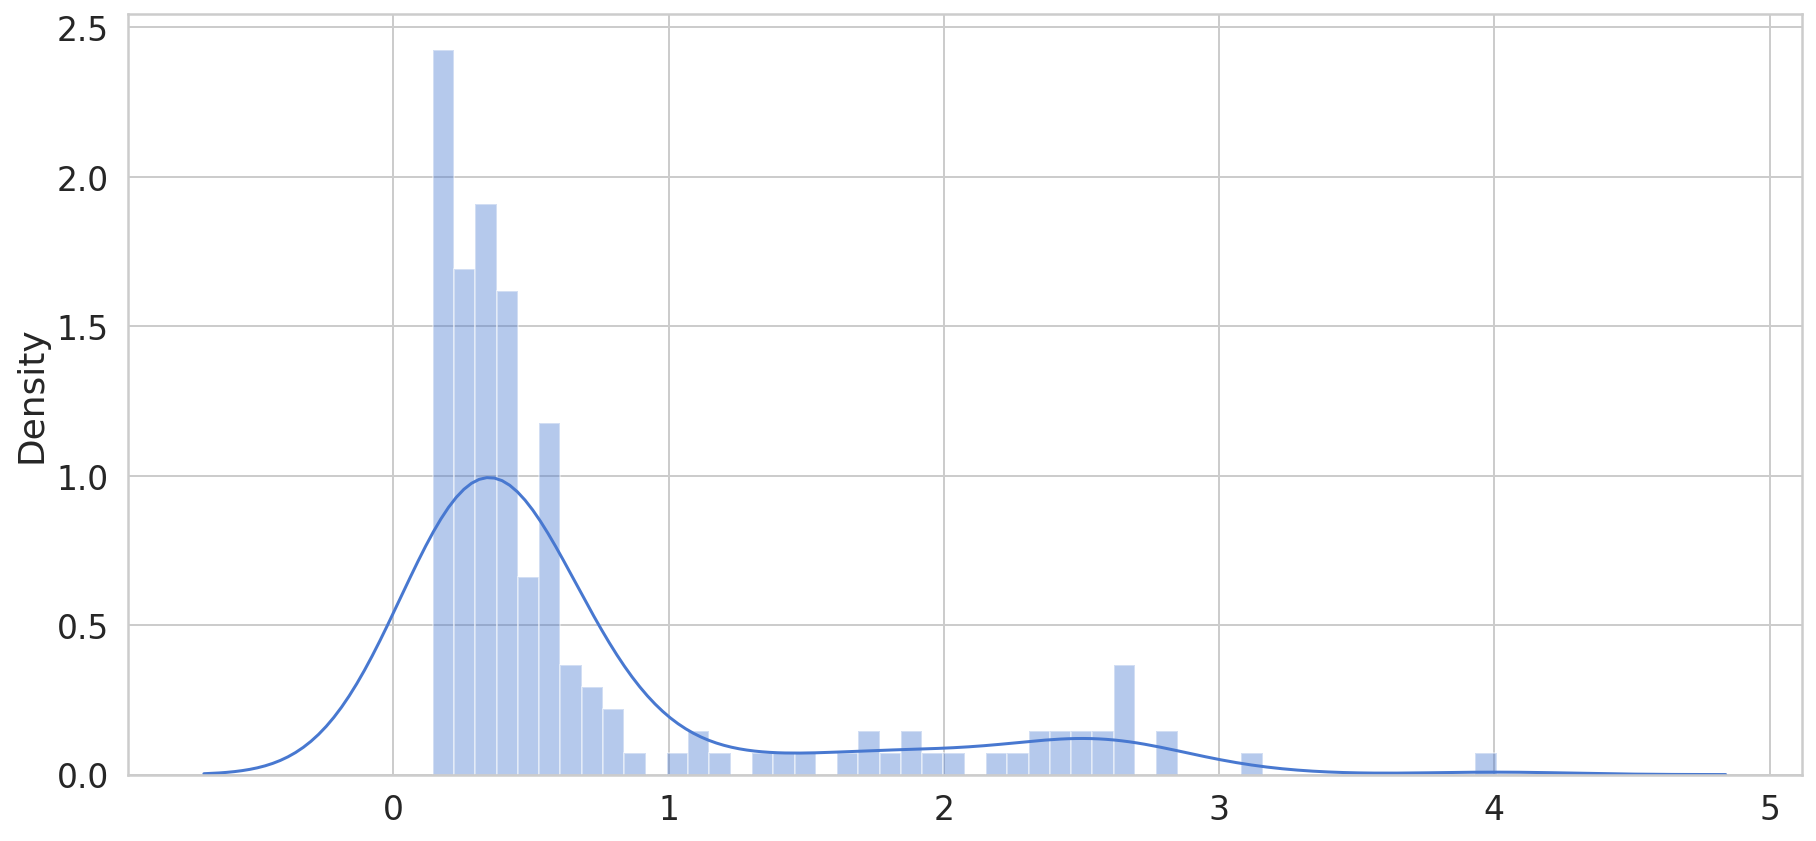

In [35]:
sns.distplot(train_mae_loss, bins=50, kde=True)

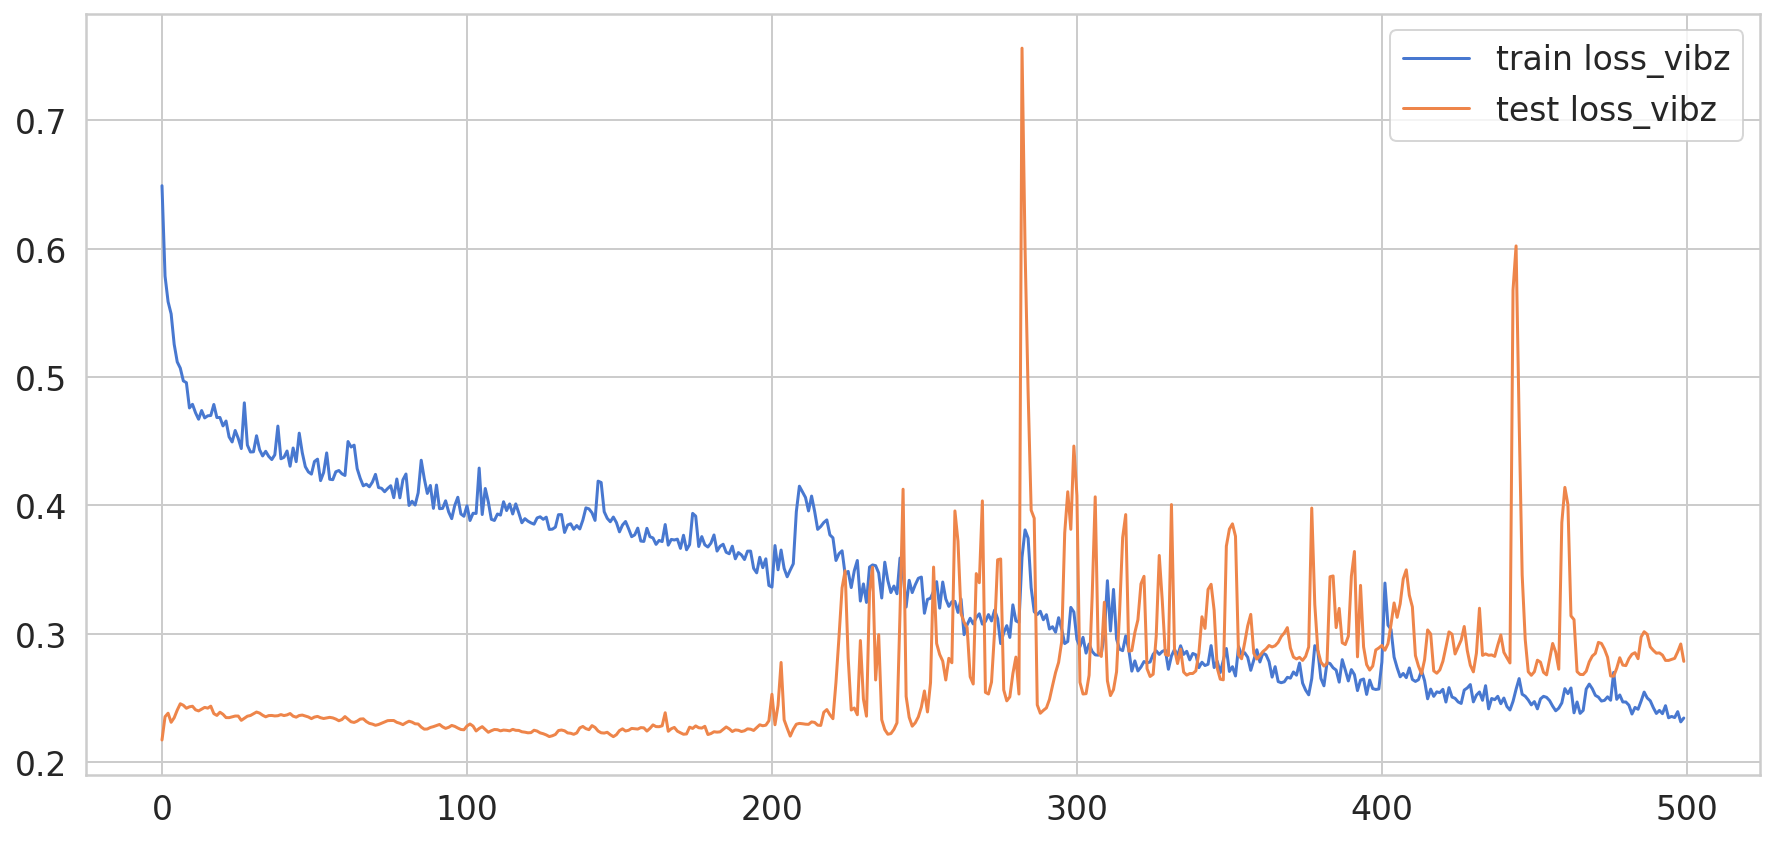

In [36]:
loss_plot()

                         loss  threshold  anomaly      vibz
Time                                                       
2020-01-26 17:00:00  3.905614        3.1     True -0.480654
2020-01-26 18:00:00  3.821351        3.1     True -0.275772
2020-01-26 19:00:00  3.932299        3.1     True -0.121420
2020-01-26 20:00:00  3.705606        3.1     True -0.252659
2020-01-26 21:00:00  3.577428        3.1     True  0.242511
2020-01-26 22:00:00  3.386967        3.1     True -0.082579
2020-01-26 23:00:00  3.352602        3.1     True -0.023441
2020-01-27 00:00:00  3.385635        3.1     True -0.298001
2020-02-02 17:00:00  4.001730        3.1     True  0.076423
2020-02-02 18:00:00  3.602817        3.1     True -0.104014


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


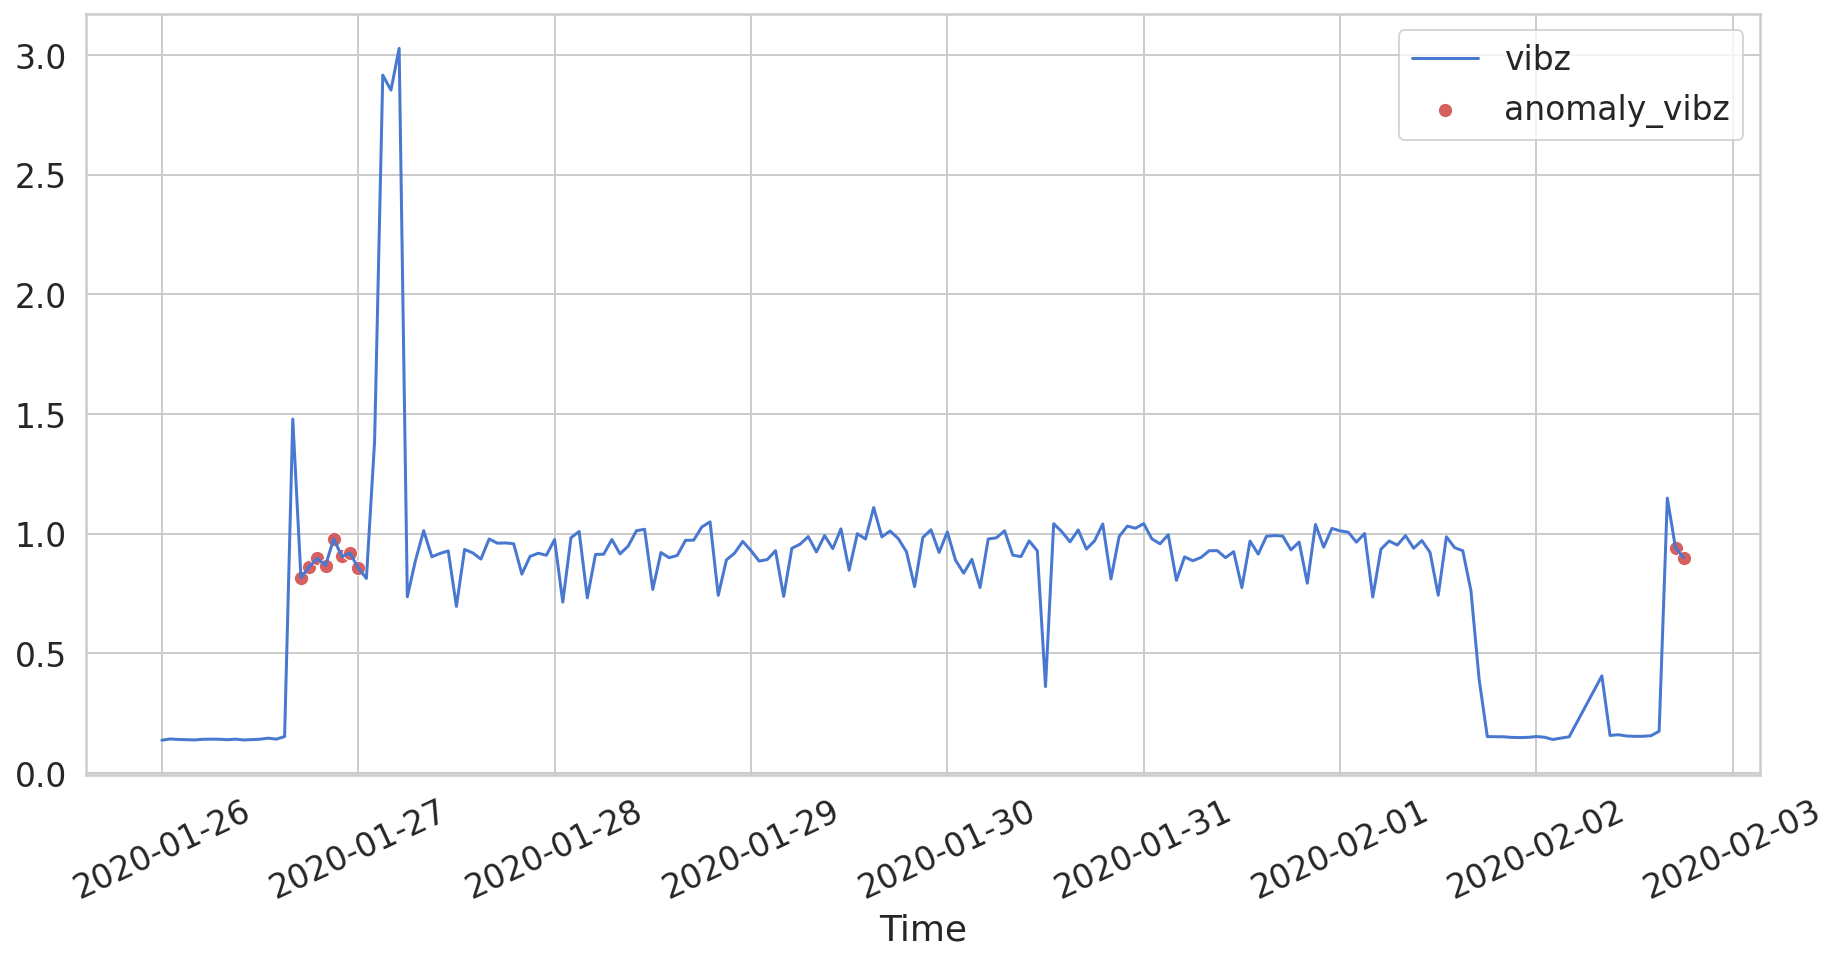

In [37]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly      vibz
Time                                                       
2020-01-19 04:00:00  3.110503        3.1     True -3.461345
2020-01-19 16:00:00  4.008742        3.1     True  2.083871


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


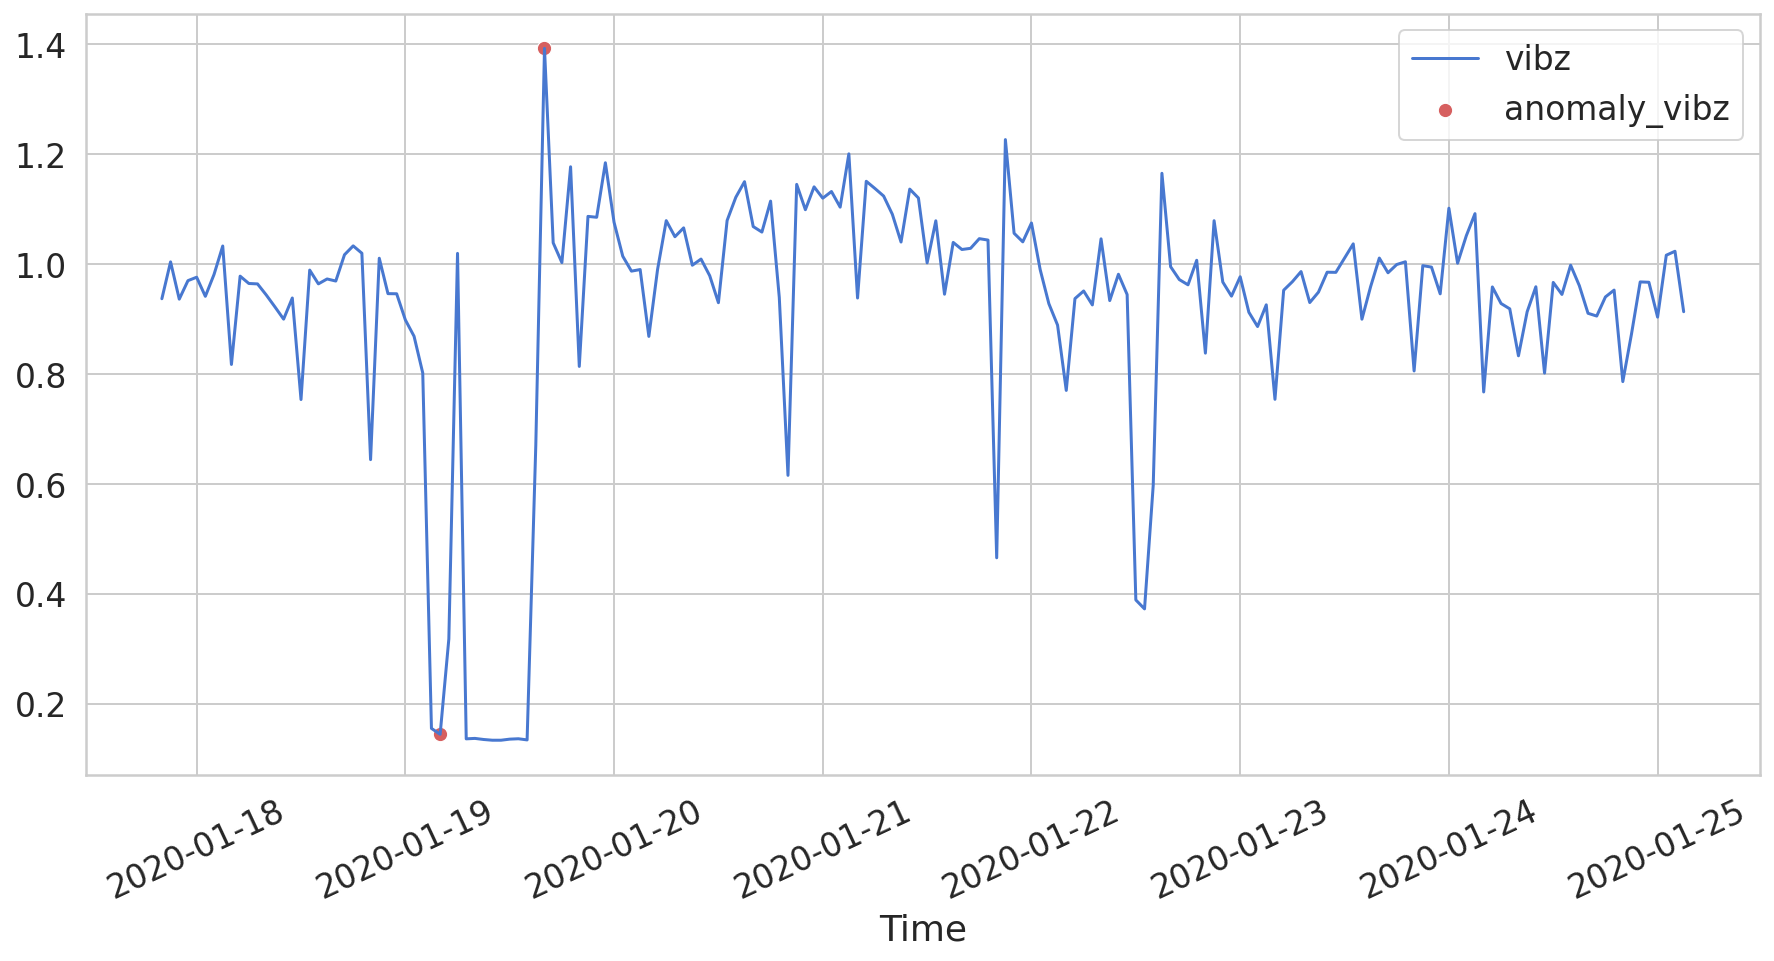

In [38]:
anomaly_plot(train,anomalies=anomalies_train)

# temp

In [39]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="temp",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

temp**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 161ms/step - loss: 0.6710 - val_loss: 0.3788
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5864 - val_loss: 0.3118
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5228 - val_loss: 0.2523
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5081 - val_loss: 0.2341
Epoch 5/500
5/5 [==============================] - 0s 17ms/step - loss: 0.4819 - val_loss: 0.2249
Epoch 6/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4751 - val_loss: 0.2217
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4526 - val_loss: 0.2292
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4316 - val_loss: 0.2287
Epoch 9/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4173 - val_loss: 0.2173
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3981 - val_loss: 0.2093
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


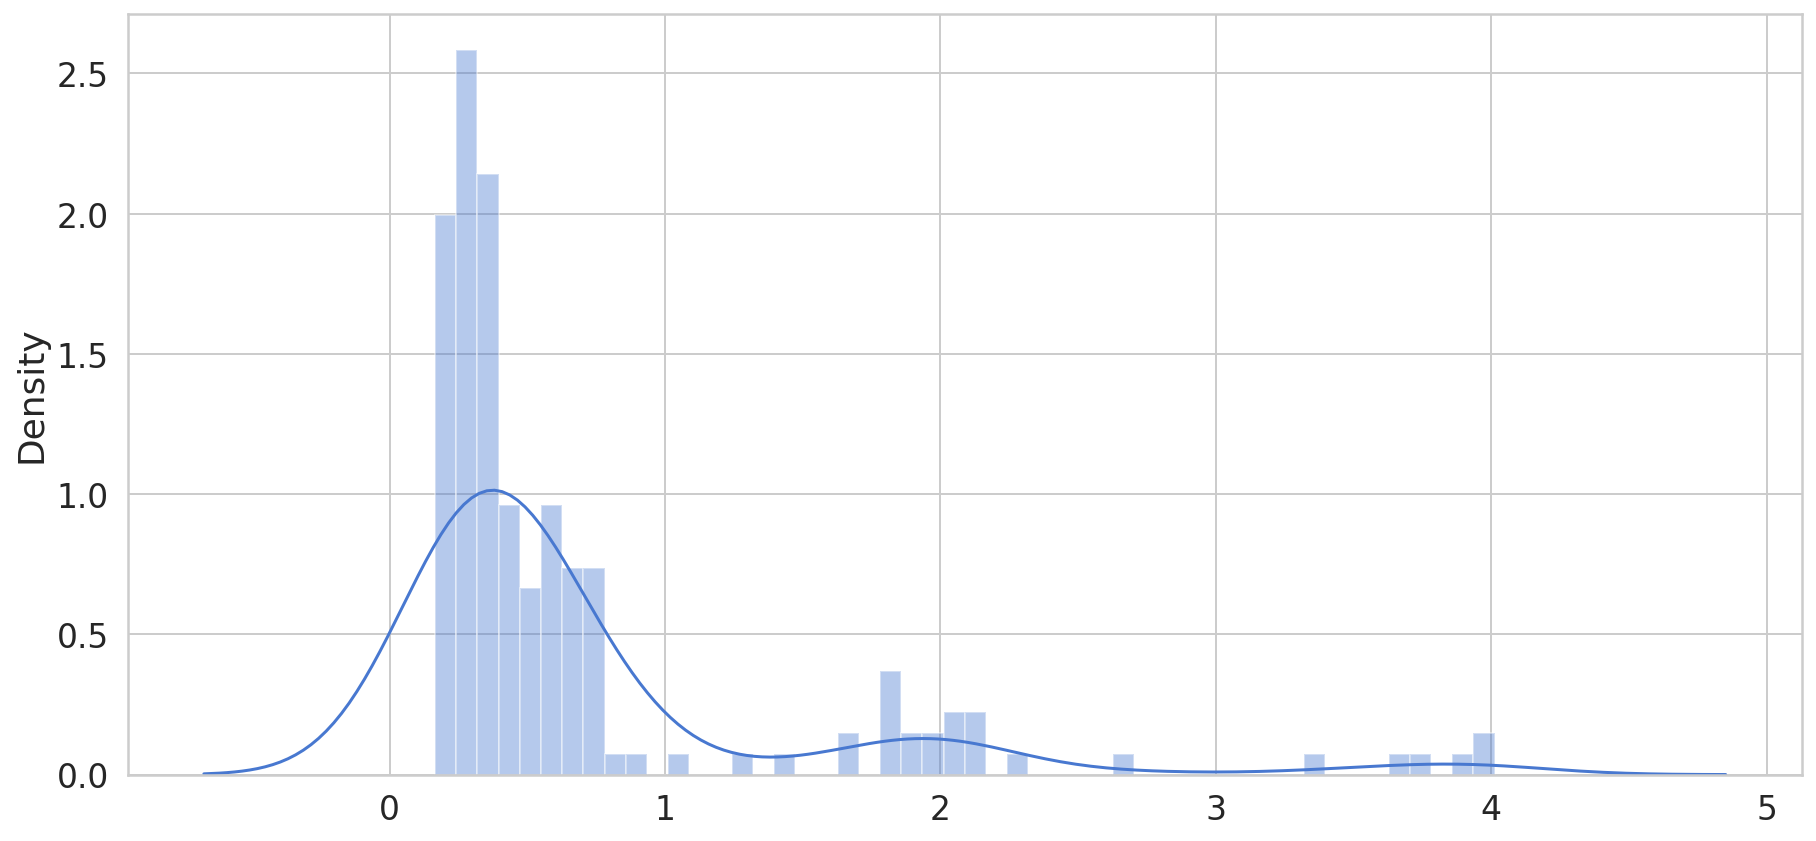

In [40]:
sns.distplot(train_mae_loss, bins=50, kde=True)

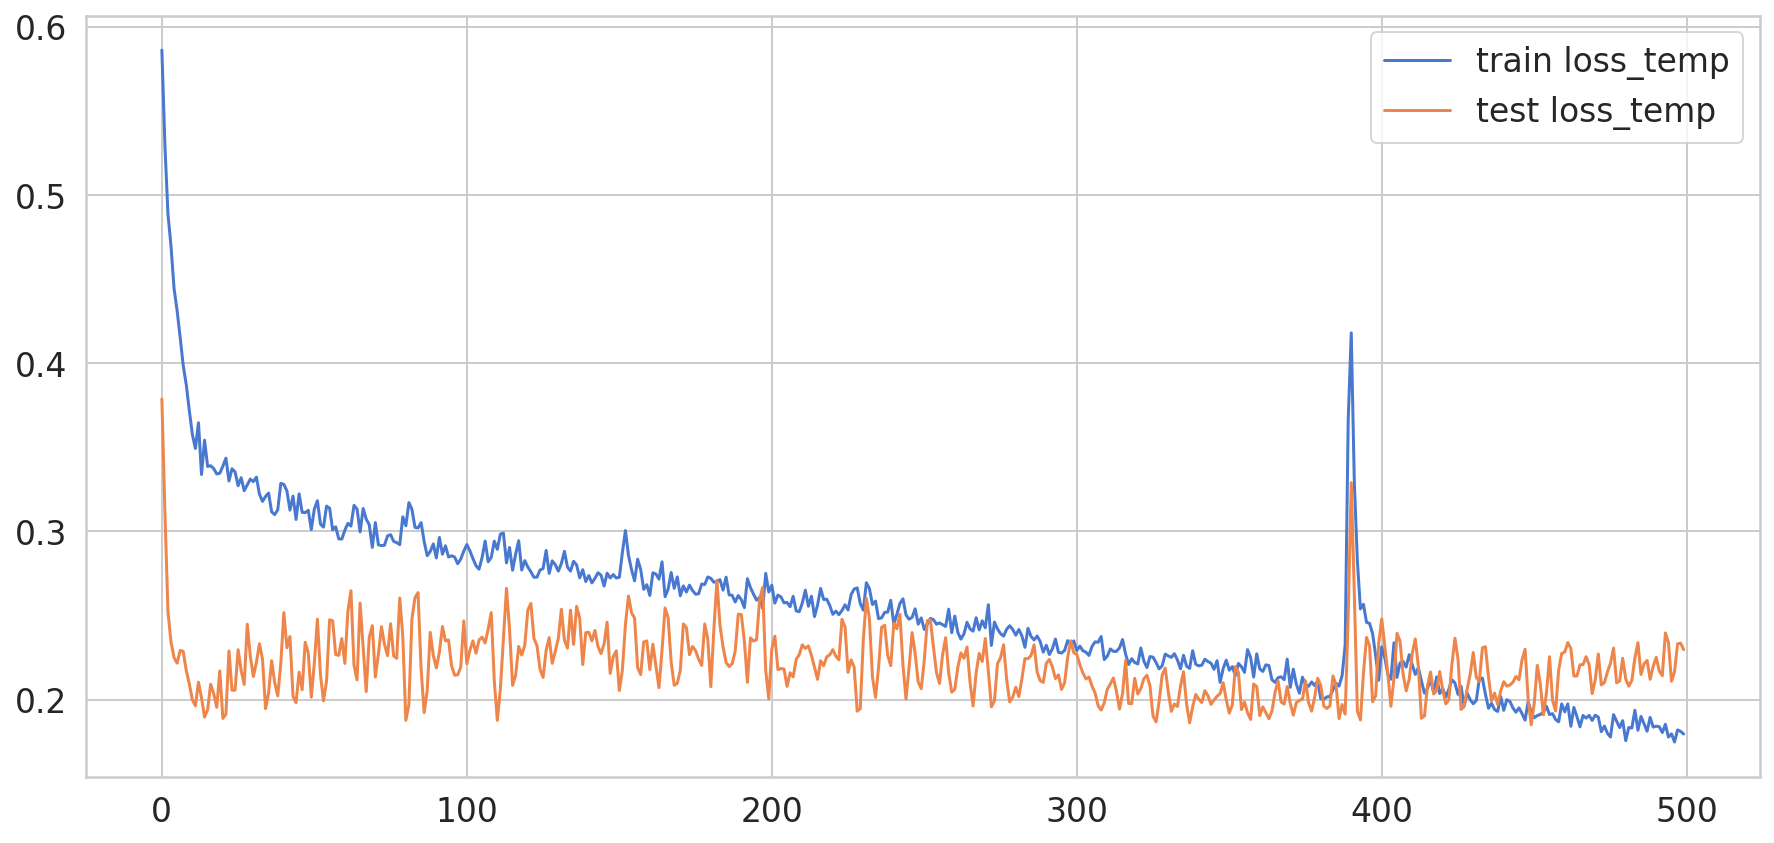

In [41]:
loss_plot()

                         loss  threshold  anomaly      temp
Time                                                       
2020-01-26 00:00:00  3.129669        3.1     True -3.332004
2020-01-26 01:00:00  3.443245        3.1     True -3.898407
2020-01-26 02:00:00  3.660328        3.1     True -4.265653
2020-01-26 03:00:00  3.642291        3.1     True -4.510806
2020-01-26 15:00:00  3.132568        3.1     True -5.101384
2020-01-26 16:00:00  3.292094        3.1     True -3.099419
2020-01-26 17:00:00  4.055949        3.1     True -0.378030
2020-01-26 18:00:00  4.125517        3.1     True  0.877618
2020-01-26 19:00:00  3.936039        3.1     True  1.447570
2020-01-26 20:00:00  3.935984        3.1     True  2.005492


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


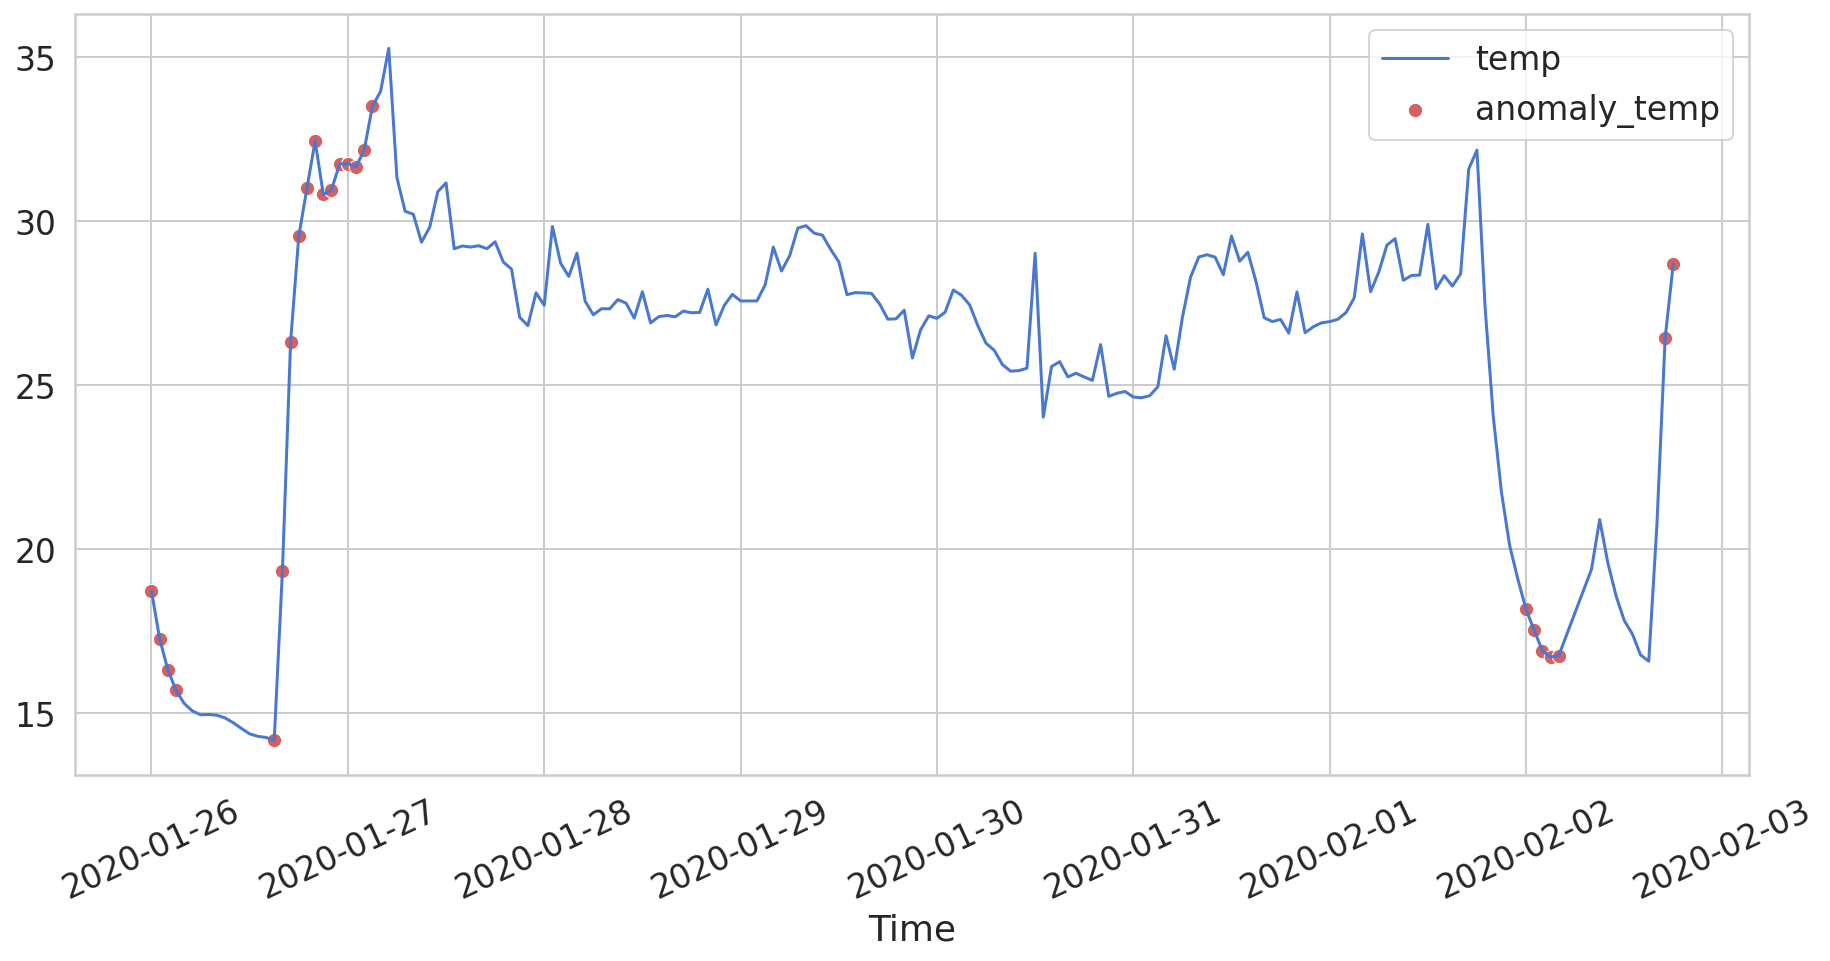

In [42]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly      temp
Time                                                       
2020-01-19 10:00:00  3.362714        3.1     True -3.274848
2020-01-19 11:00:00  3.708700        3.1     True -3.836741
2020-01-19 12:00:00  3.912426        3.1     True -4.265956
2020-01-19 13:00:00  4.011850        3.1     True -4.598260
2020-01-19 14:00:00  3.997079        3.1     True -4.861006
2020-01-19 15:00:00  3.676519        3.1     True -4.821381


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


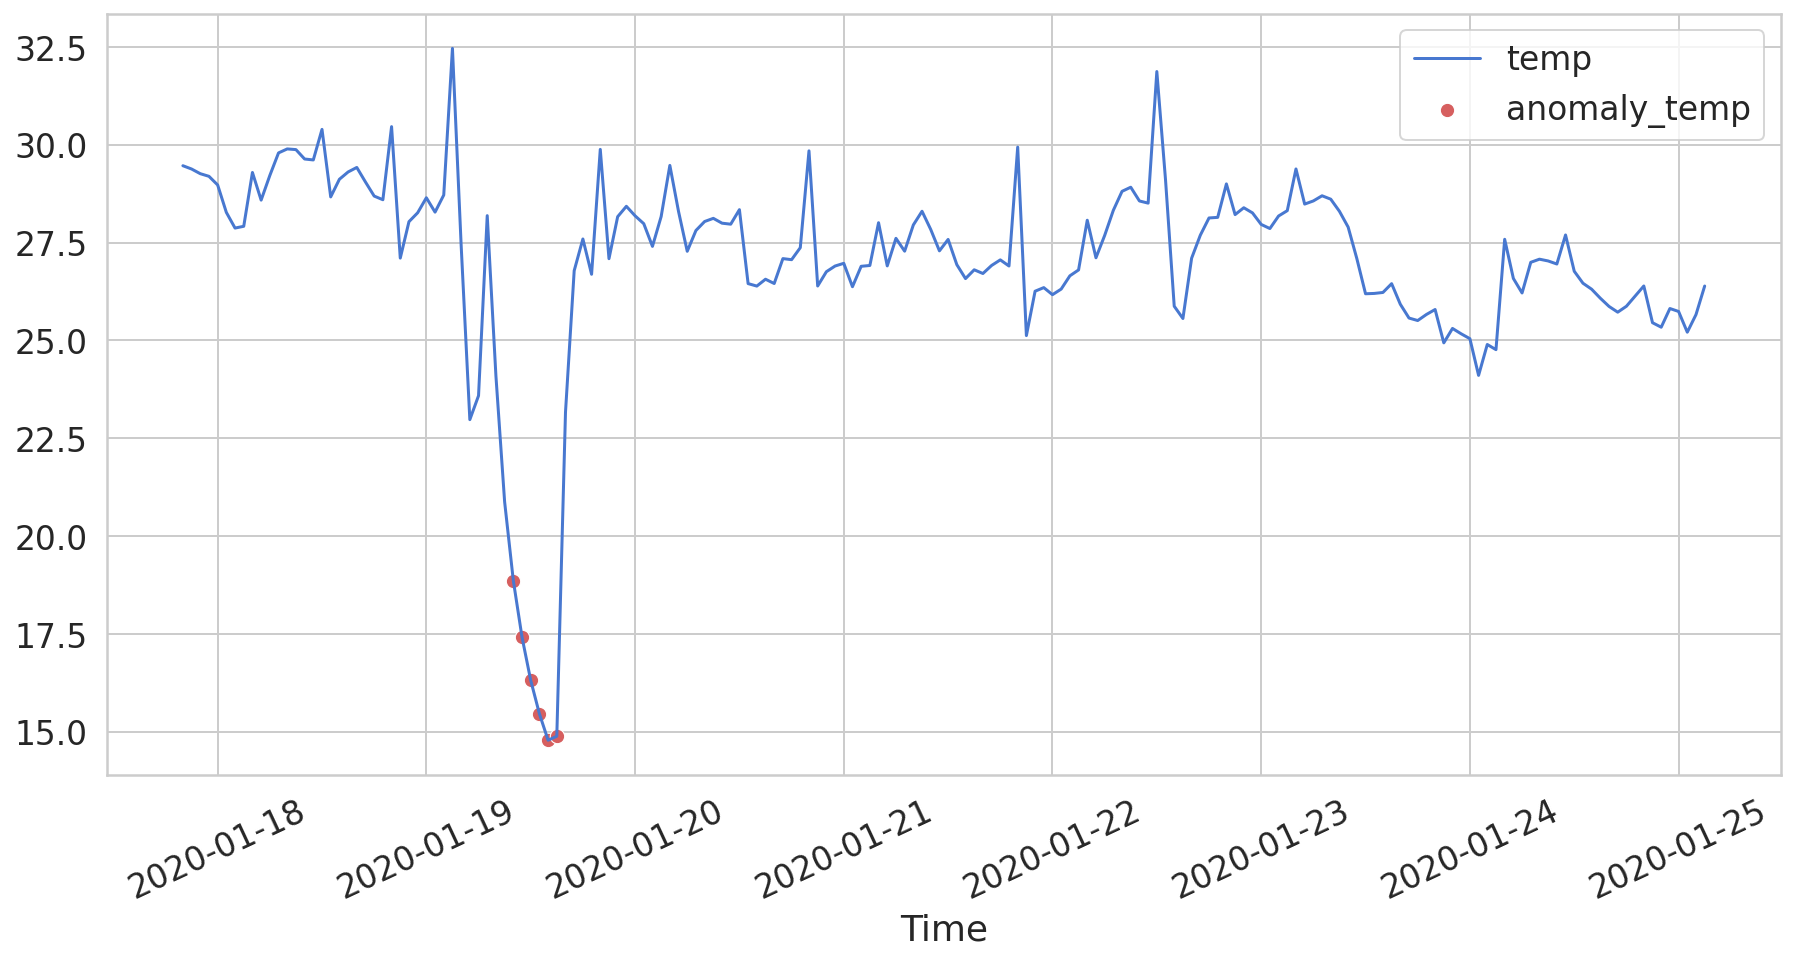

In [43]:
anomaly_plot(train,anomalies=anomalies_train)

# zacc

In [44]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zacc",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zacc**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 167ms/step - loss: 0.7068 - val_loss: 0.1480
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 0.6337 - val_loss: 0.1746
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5969 - val_loss: 0.1842
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5815 - val_loss: 0.1693
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5761 - val_loss: 0.1626
Epoch 6/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5595 - val_loss: 0.1672
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5503 - val_loss: 0.1742
Epoch 8/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5259 - val_loss: 0.1719
Epoch 9/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5275 - val_loss: 0.1687
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5125 - val_loss: 0.1715
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


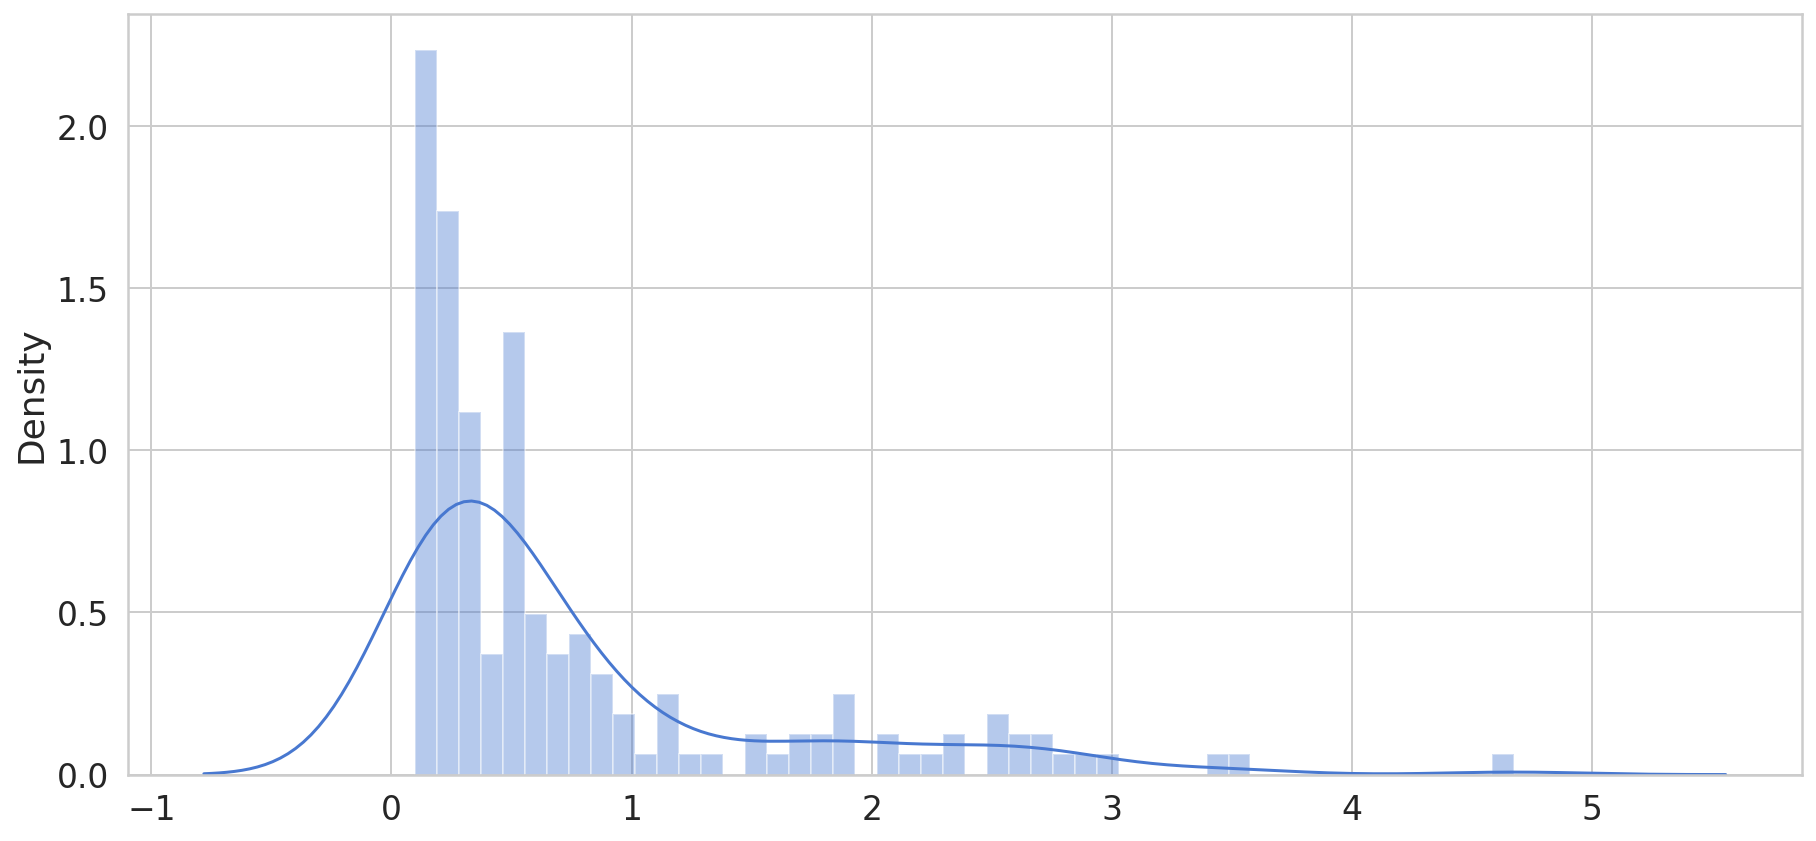

In [45]:
sns.distplot(train_mae_loss, bins=50, kde=True)

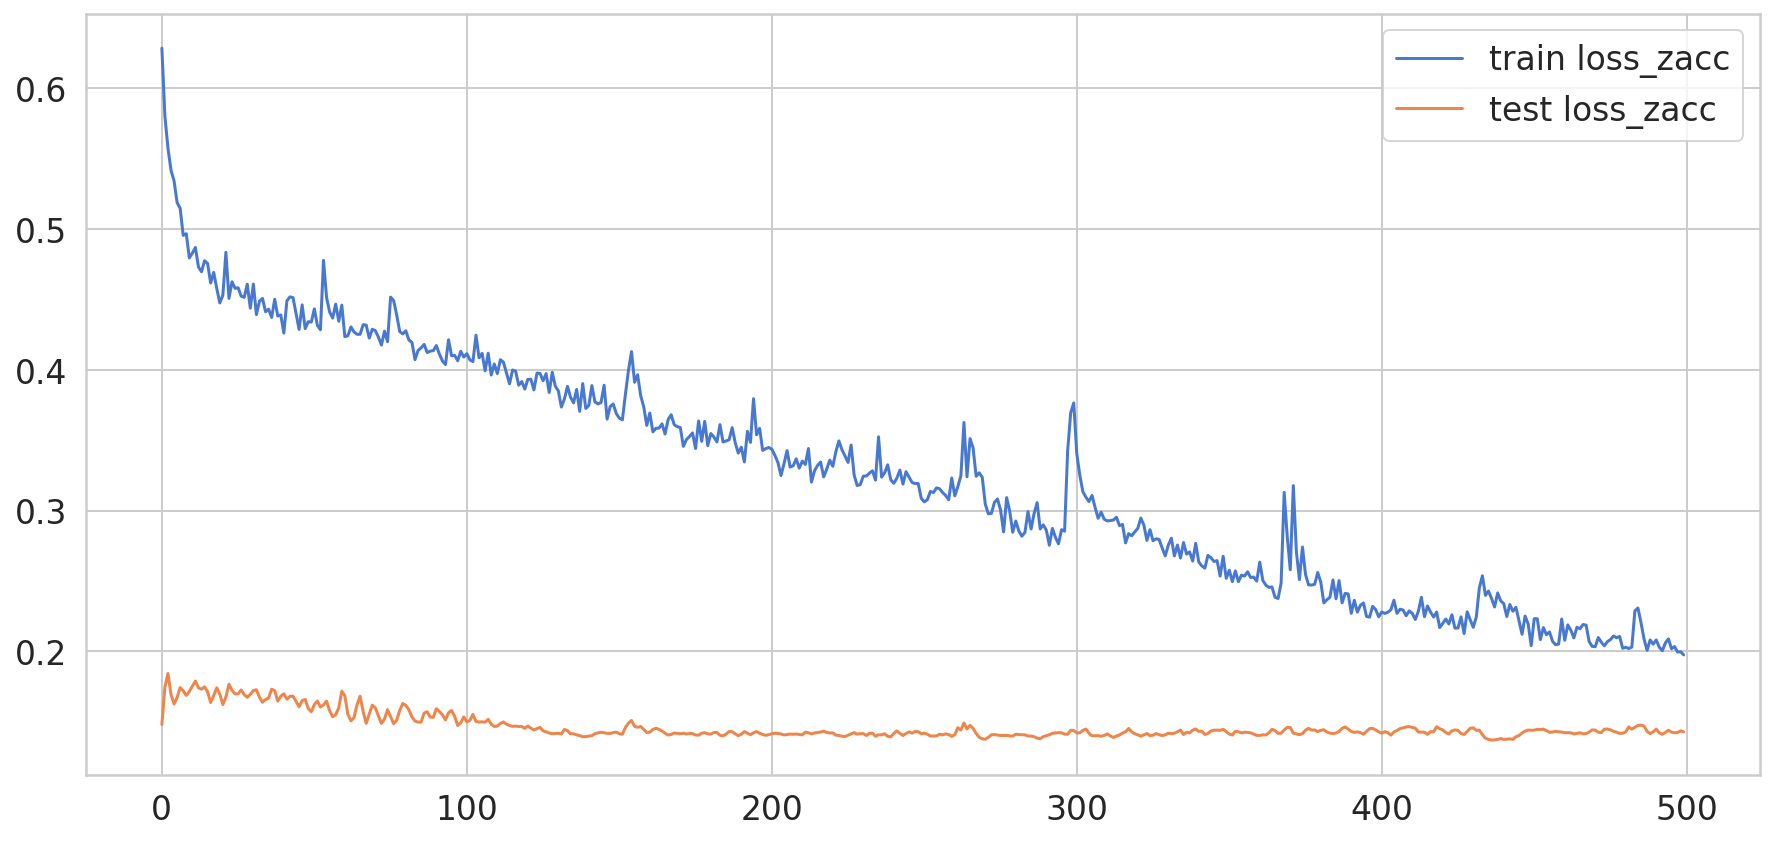

In [46]:
loss_plot()

                         loss  threshold  anomaly      zacc
Time                                                       
2020-01-26 06:00:00  3.409904        3.1     True -2.582749
2020-01-26 07:00:00  3.446562        3.1     True -2.872798
2020-01-26 08:00:00  3.308769        3.1     True -2.992956
2020-01-26 09:00:00  3.399735        3.1     True -2.839901
2020-01-26 10:00:00  3.540623        3.1     True -2.827023
2020-01-26 11:00:00  3.551568        3.1     True -3.193855
2020-01-26 12:00:00  3.147452        3.1     True -3.207793
2020-01-26 14:00:00  3.277591        3.1     True -2.989743
2020-01-26 15:00:00  3.298671        3.1     True -2.967335
2020-01-26 16:00:00  3.309937        3.1     True  2.997938


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


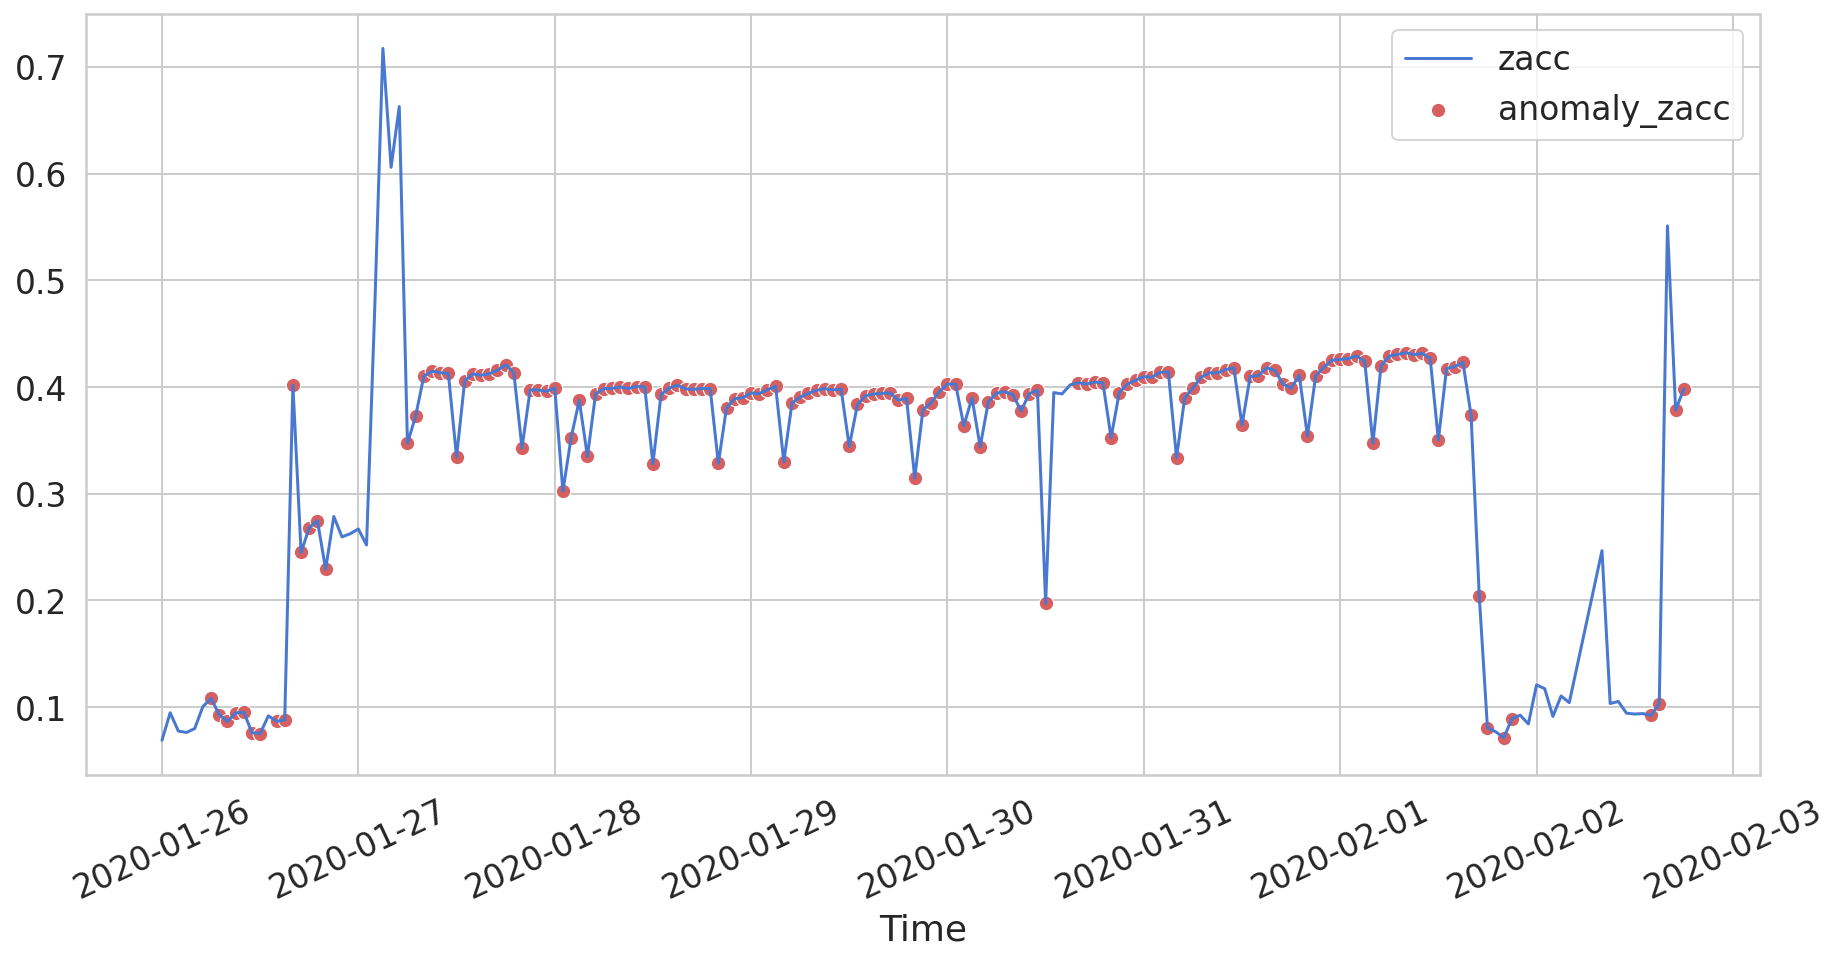

In [47]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly      zacc
Time                                                       
2020-01-19 04:00:00  3.432441        3.1     True -3.617905
2020-01-19 16:00:00  3.490564        3.1     True  1.666277
2020-01-19 19:00:00  4.676586        3.1     True  3.356645


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


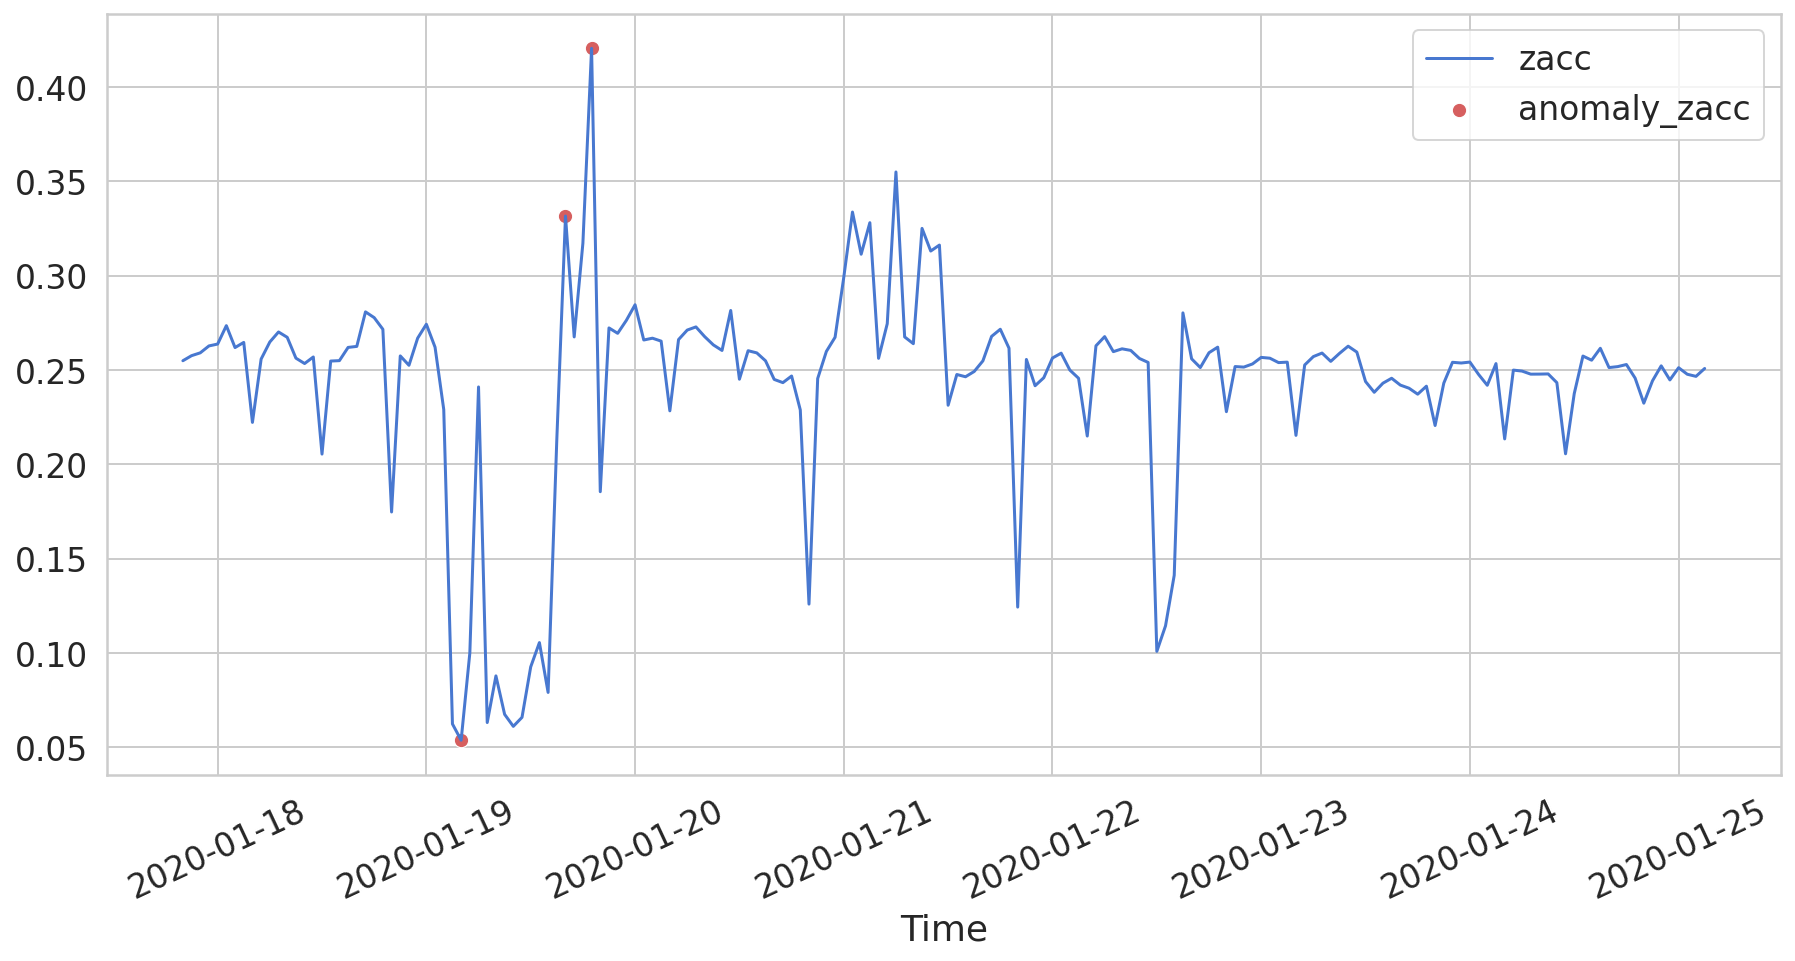

In [48]:
anomaly_plot(train,anomalies=anomalies_train)

# crest

In [49]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="crest",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

crest**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 168ms/step - loss: 0.5970 - val_loss: 0.1745
Epoch 2/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5030 - val_loss: 0.1397
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4949 - val_loss: 0.1112
Epoch 4/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4596 - val_loss: 0.1228
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4250 - val_loss: 0.1104
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4197 - val_loss: 0.1062
Epoch 7/500
5/5 [==============================] - 0s 17ms/step - loss: 0.4005 - val_loss: 0.1060
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3947 - val_loss: 0.1197
Epoch 9/500
5/5 [==============================] - 0s 16ms/step - loss: 0.3852 - val_loss: 0.1129
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3770 - val_loss: 0.0987
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


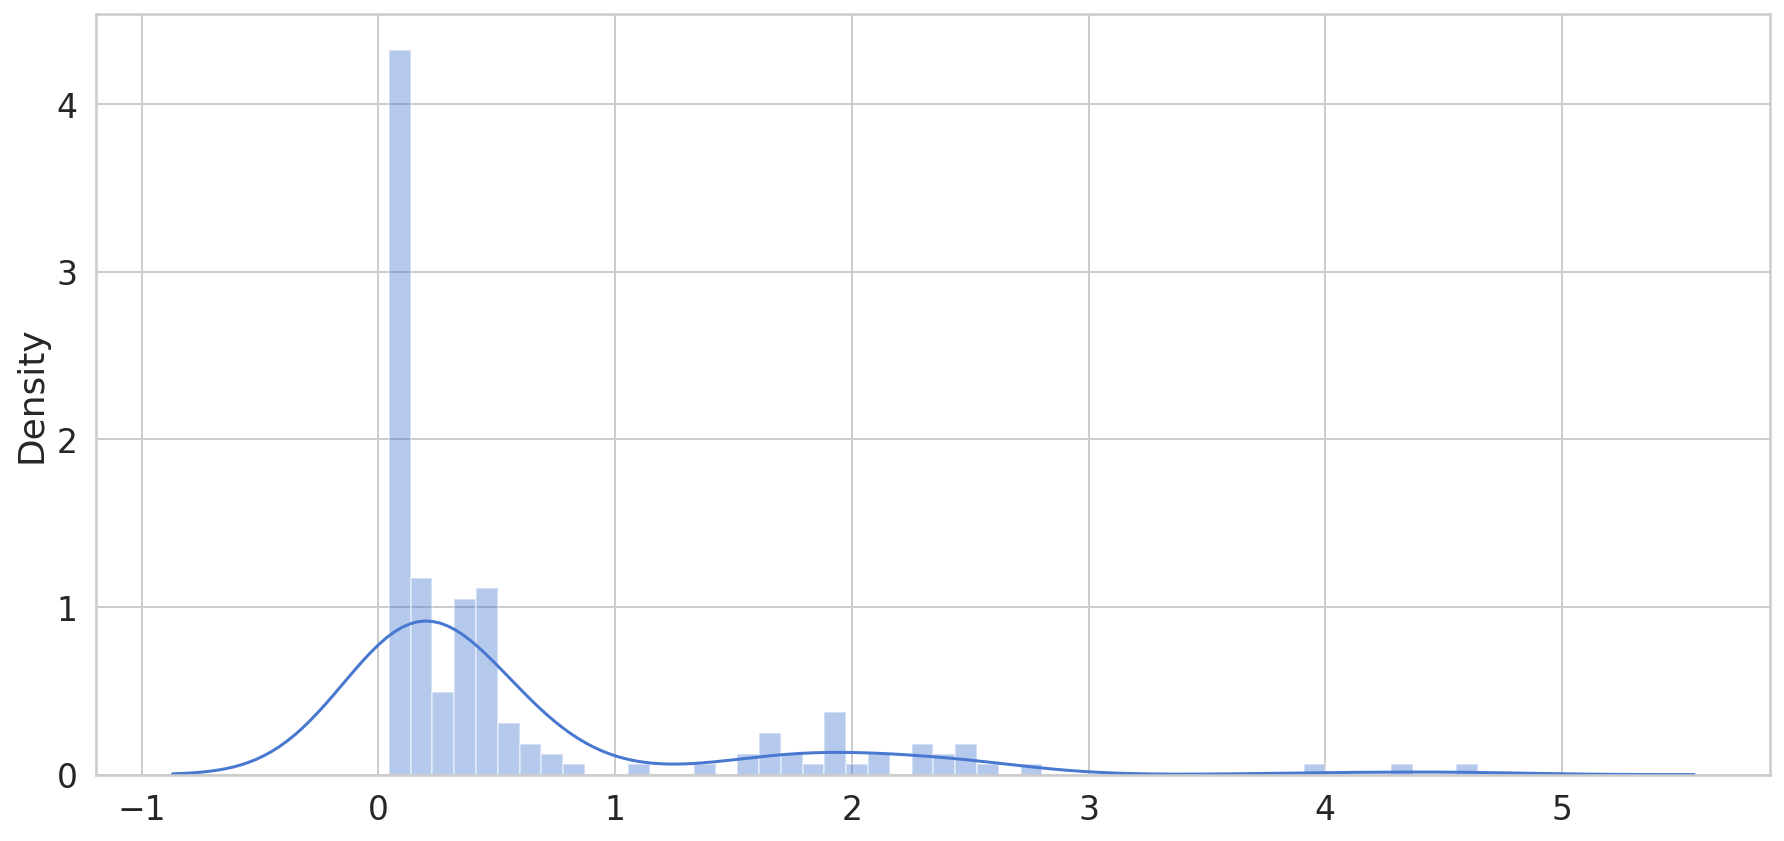

In [50]:
sns.distplot(train_mae_loss, bins=50, kde=True)

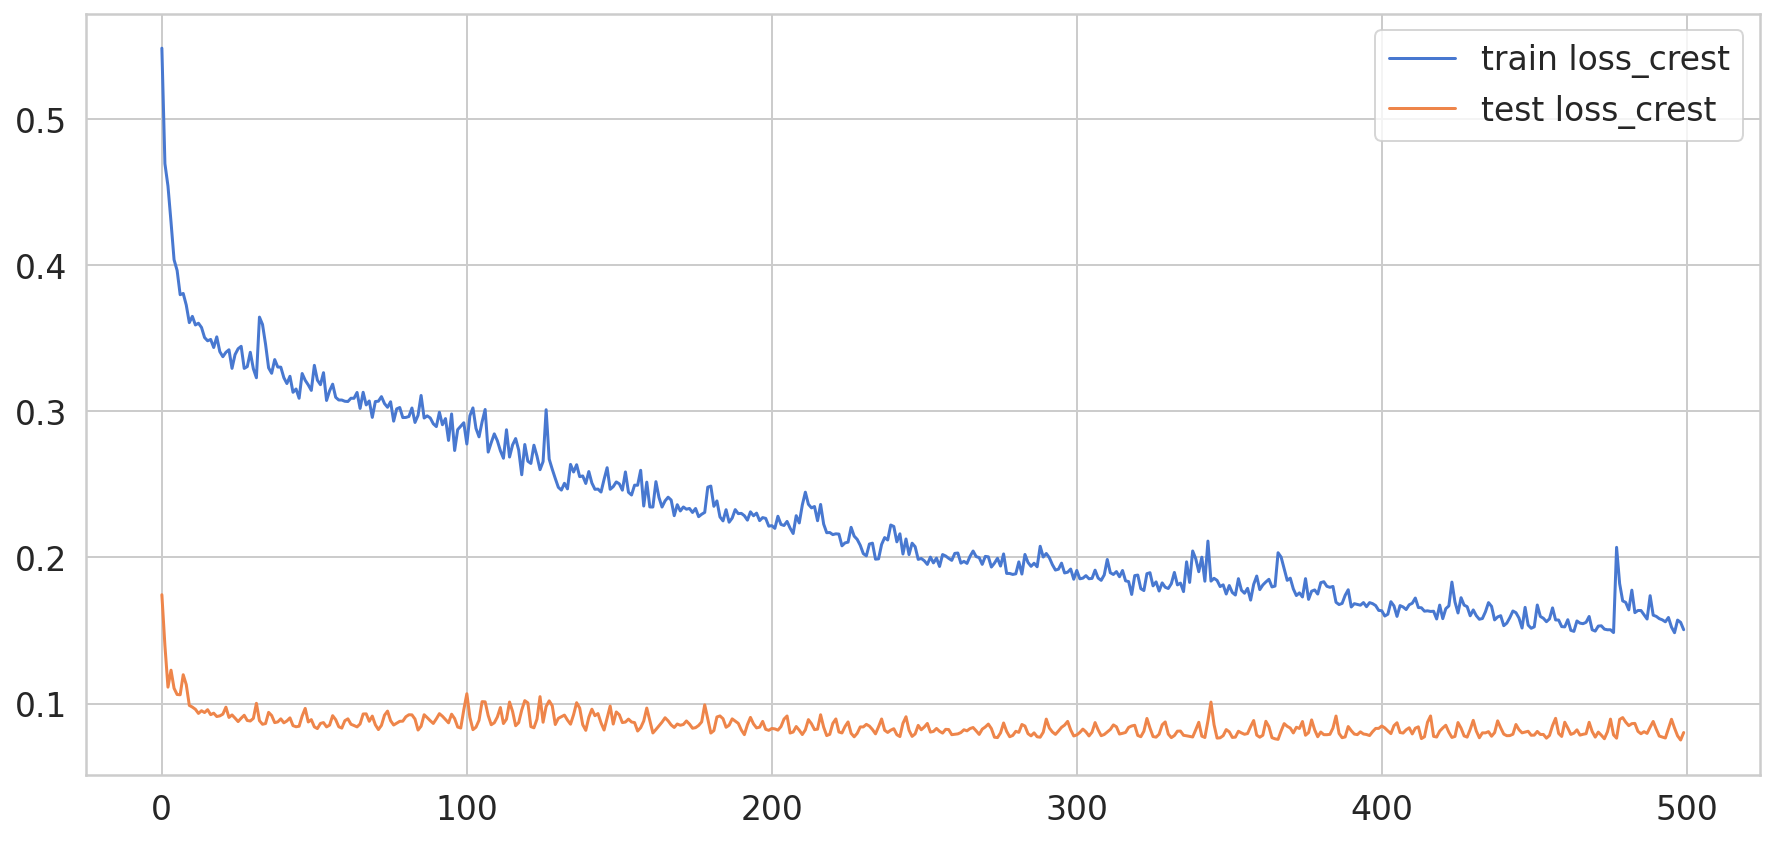

In [51]:
loss_plot()

                         loss  threshold  anomaly     crest
Time                                                       
2020-01-26 03:00:00  3.642361        3.1     True  3.552195
2020-01-26 18:00:00  4.132711        3.1     True -0.492361
2020-01-26 19:00:00  3.187127        3.1     True -0.444084
2020-01-26 21:00:00  3.567793        3.1     True -0.381597
2020-01-26 22:00:00  3.458690        3.1     True -0.564350
2020-01-26 23:00:00  3.263980        3.1     True -0.524380
2020-02-01 22:00:00  4.132634        3.1     True  4.019368
2020-02-02 17:00:00  3.859544        3.1     True -0.544915
2020-02-02 18:00:00  3.718119        3.1     True -0.656380


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


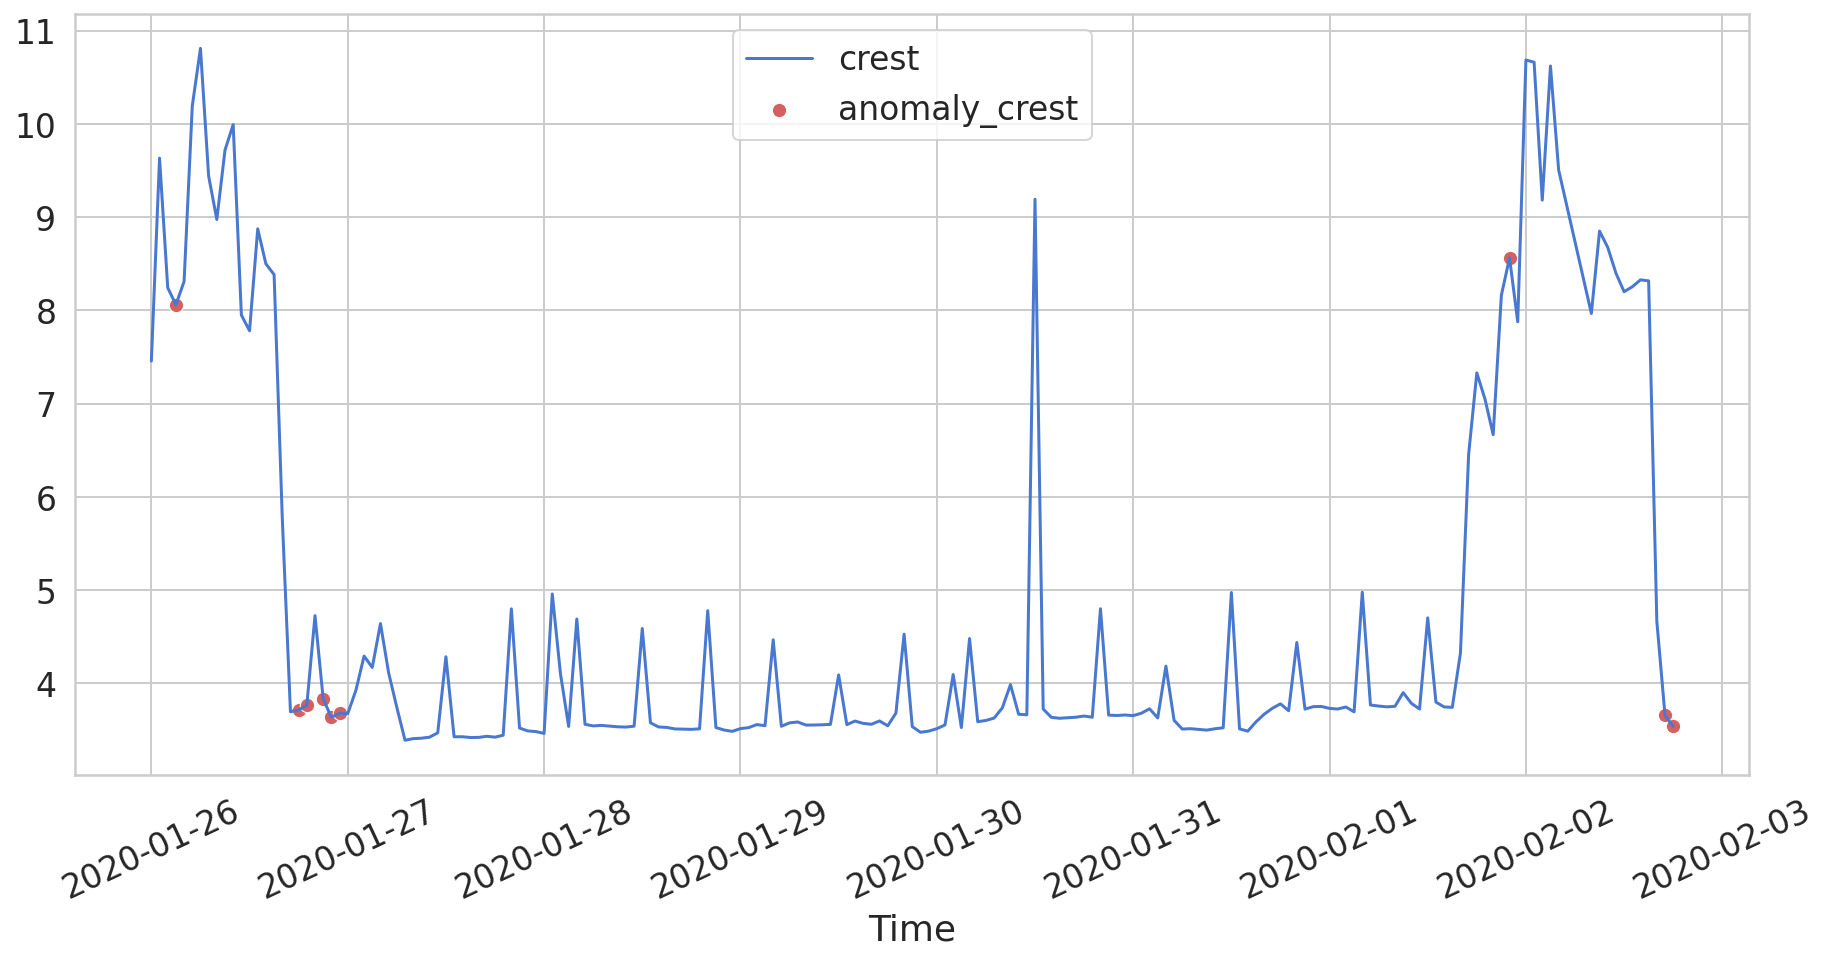

In [52]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly     crest
Time                                                       
2020-01-19 08:00:00  4.361821        3.1     True  4.794238
2020-01-19 12:00:00  3.944735        3.1     True  5.080041
2020-01-19 13:00:00  4.644419        3.1     True  6.162305


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


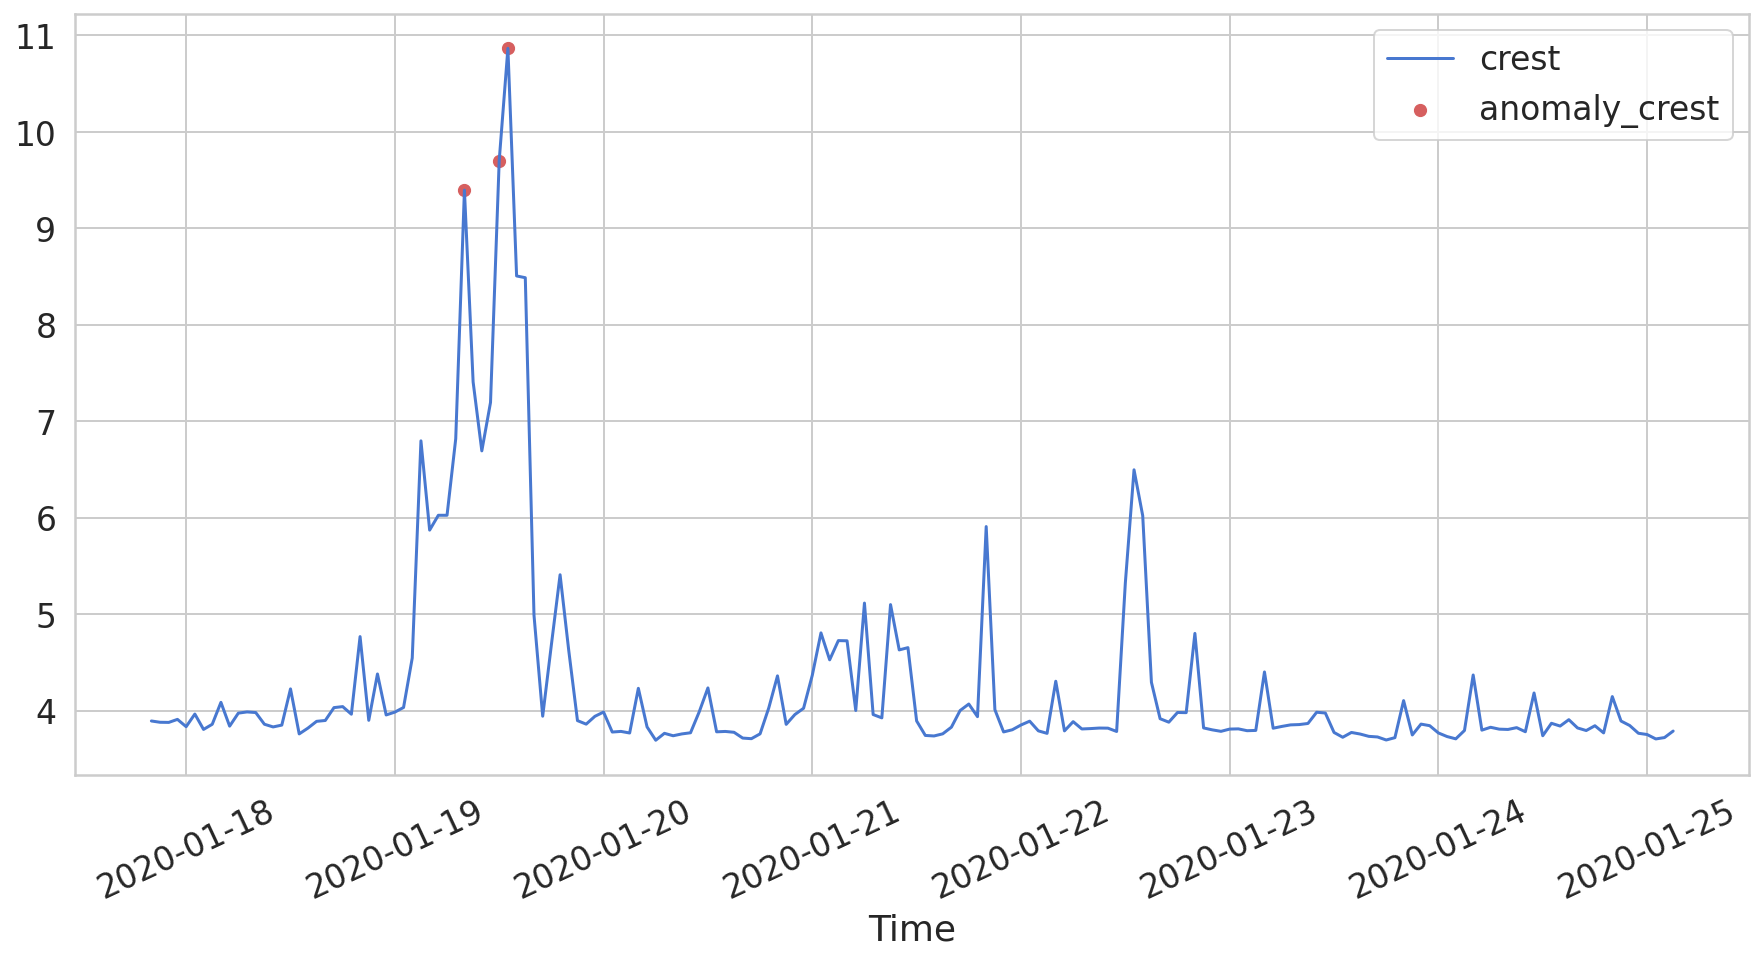

In [53]:
anomaly_plot(train,anomalies=anomalies_train)

# zfreq

In [54]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zfreq",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zfreq**************************************************
(196, 1) (204, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 163ms/step - loss: 0.7000 - val_loss: 0.2400
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5740 - val_loss: 0.2369
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5494 - val_loss: 0.2172
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5061 - val_loss: 0.2157
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4880 - val_loss: 0.2122
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4636 - val_loss: 0.2154
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4503 - val_loss: 0.2107
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4369 - val_loss: 0.2085
Epoch 9/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4372 - val_loss: 0.2053
Epoch 10/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4205 - val_loss: 0.2067
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


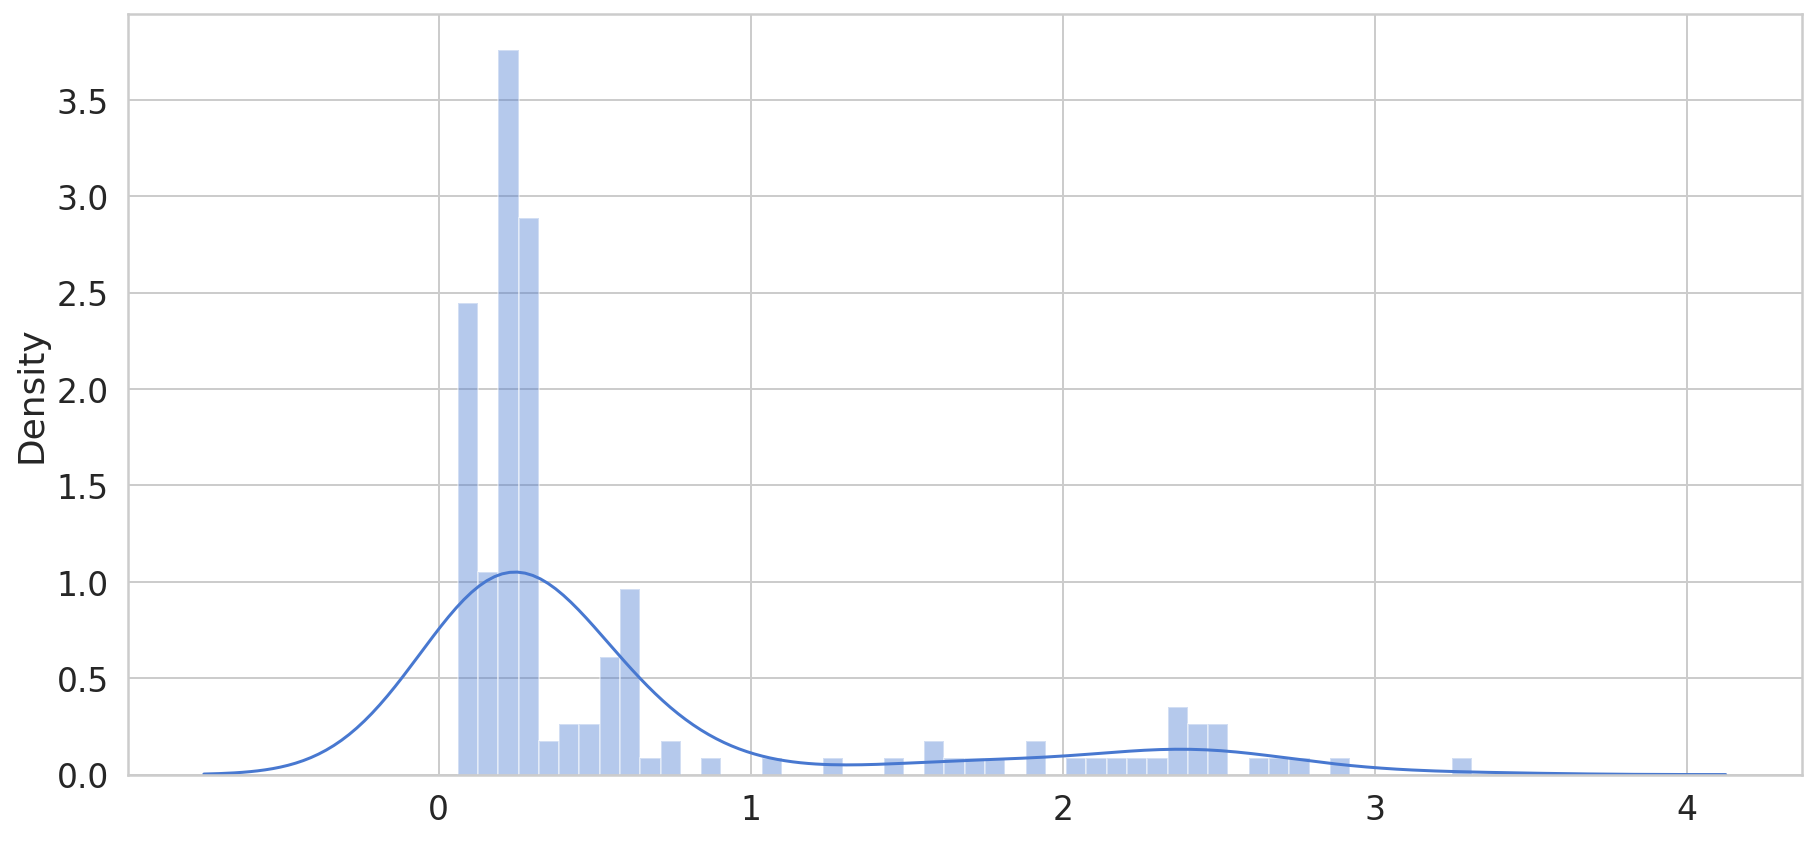

In [55]:
sns.distplot(train_mae_loss, bins=50, kde=True)

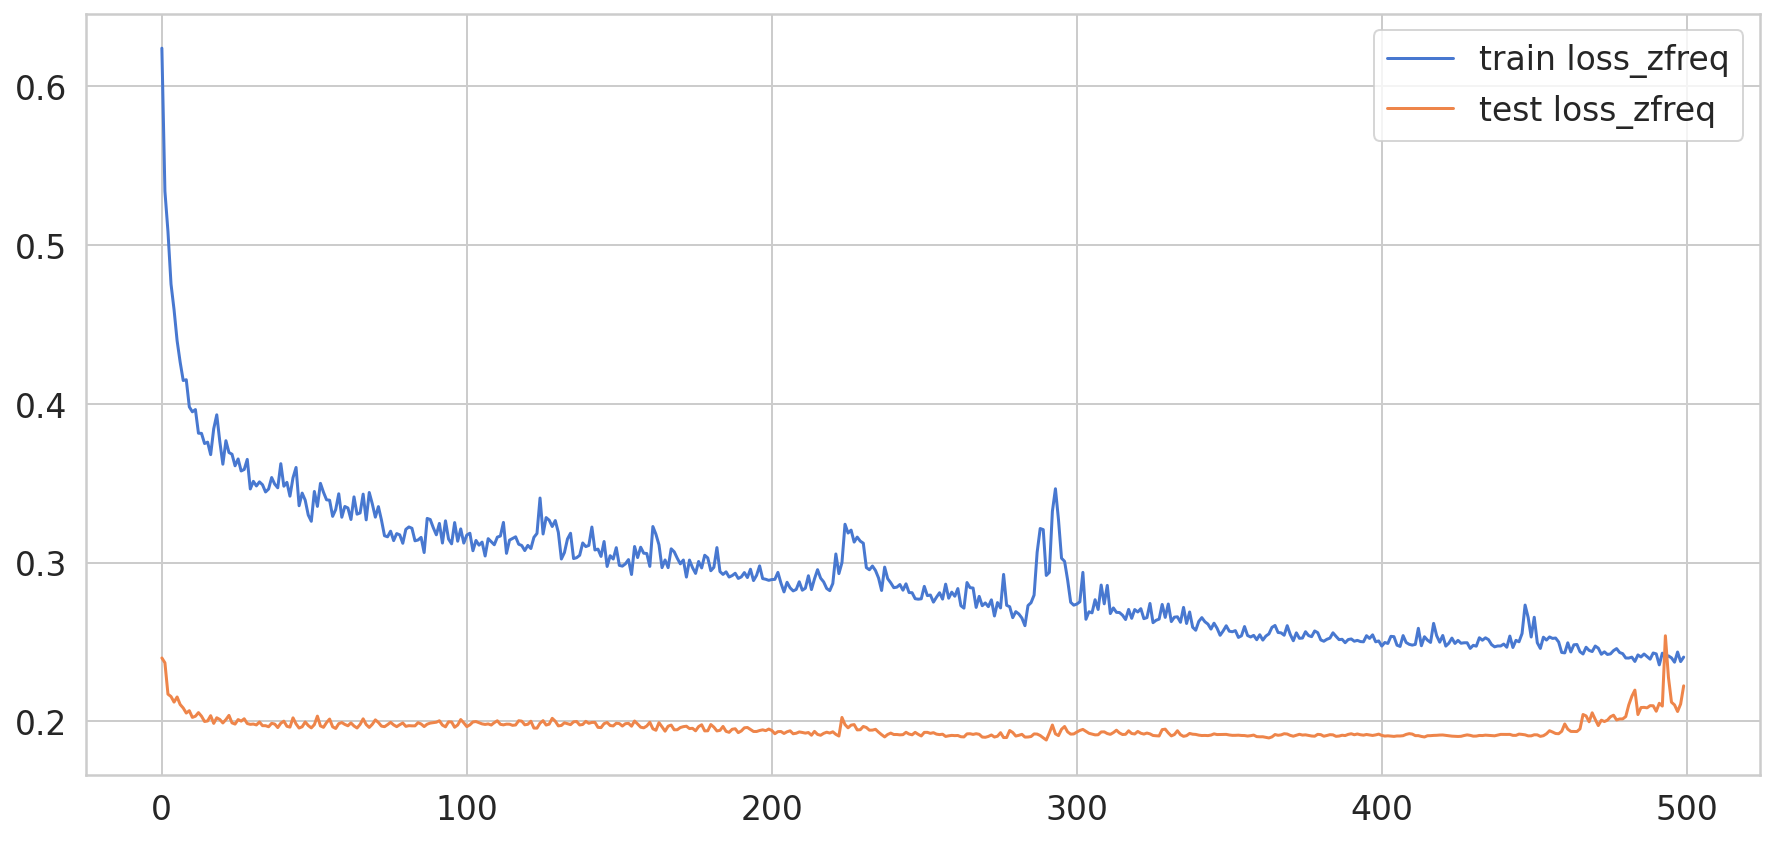

In [56]:
loss_plot()

                         loss  threshold  anomaly     zfreq
Time                                                       
2020-01-26 17:00:00  3.447822        3.1     True  0.231200
2020-01-26 18:00:00  3.390732        3.1     True  0.705166
2020-01-26 19:00:00  3.314253        3.1     True  0.579868
2020-01-26 20:00:00  3.136624        3.1     True -0.618062
2020-01-27 20:00:00  3.230107        3.1     True  1.972263
2020-01-27 21:00:00  3.321955        3.1     True  3.180056
2020-01-27 22:00:00  3.441538        3.1     True  3.284354
2020-01-27 23:00:00  3.453812        3.1     True  3.306741
2020-01-28 00:00:00  3.260201        3.1     True  3.470169
2020-01-28 01:00:00  3.136999        3.1     True  1.181340


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


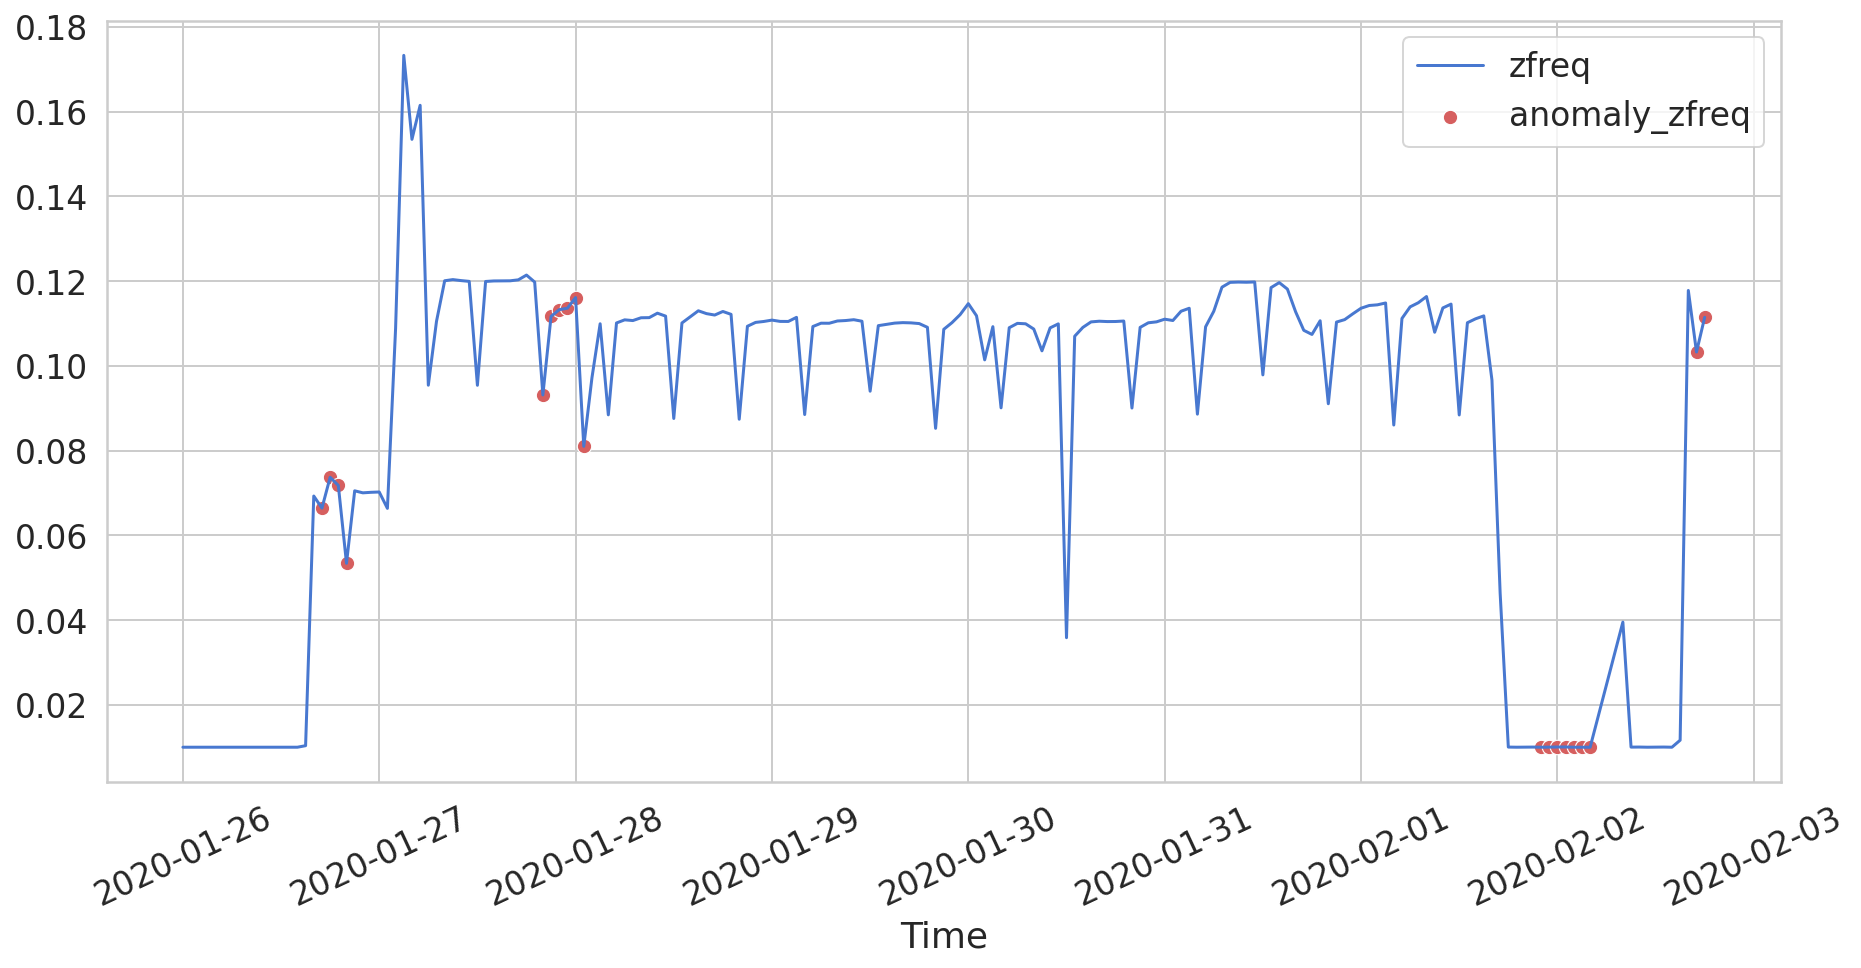

In [57]:
anomaly_plot(test,anomalies=anomalies)

                         loss  threshold  anomaly     zfreq
Time                                                       
2020-01-19 04:00:00  3.310285        3.1     True -3.447845


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


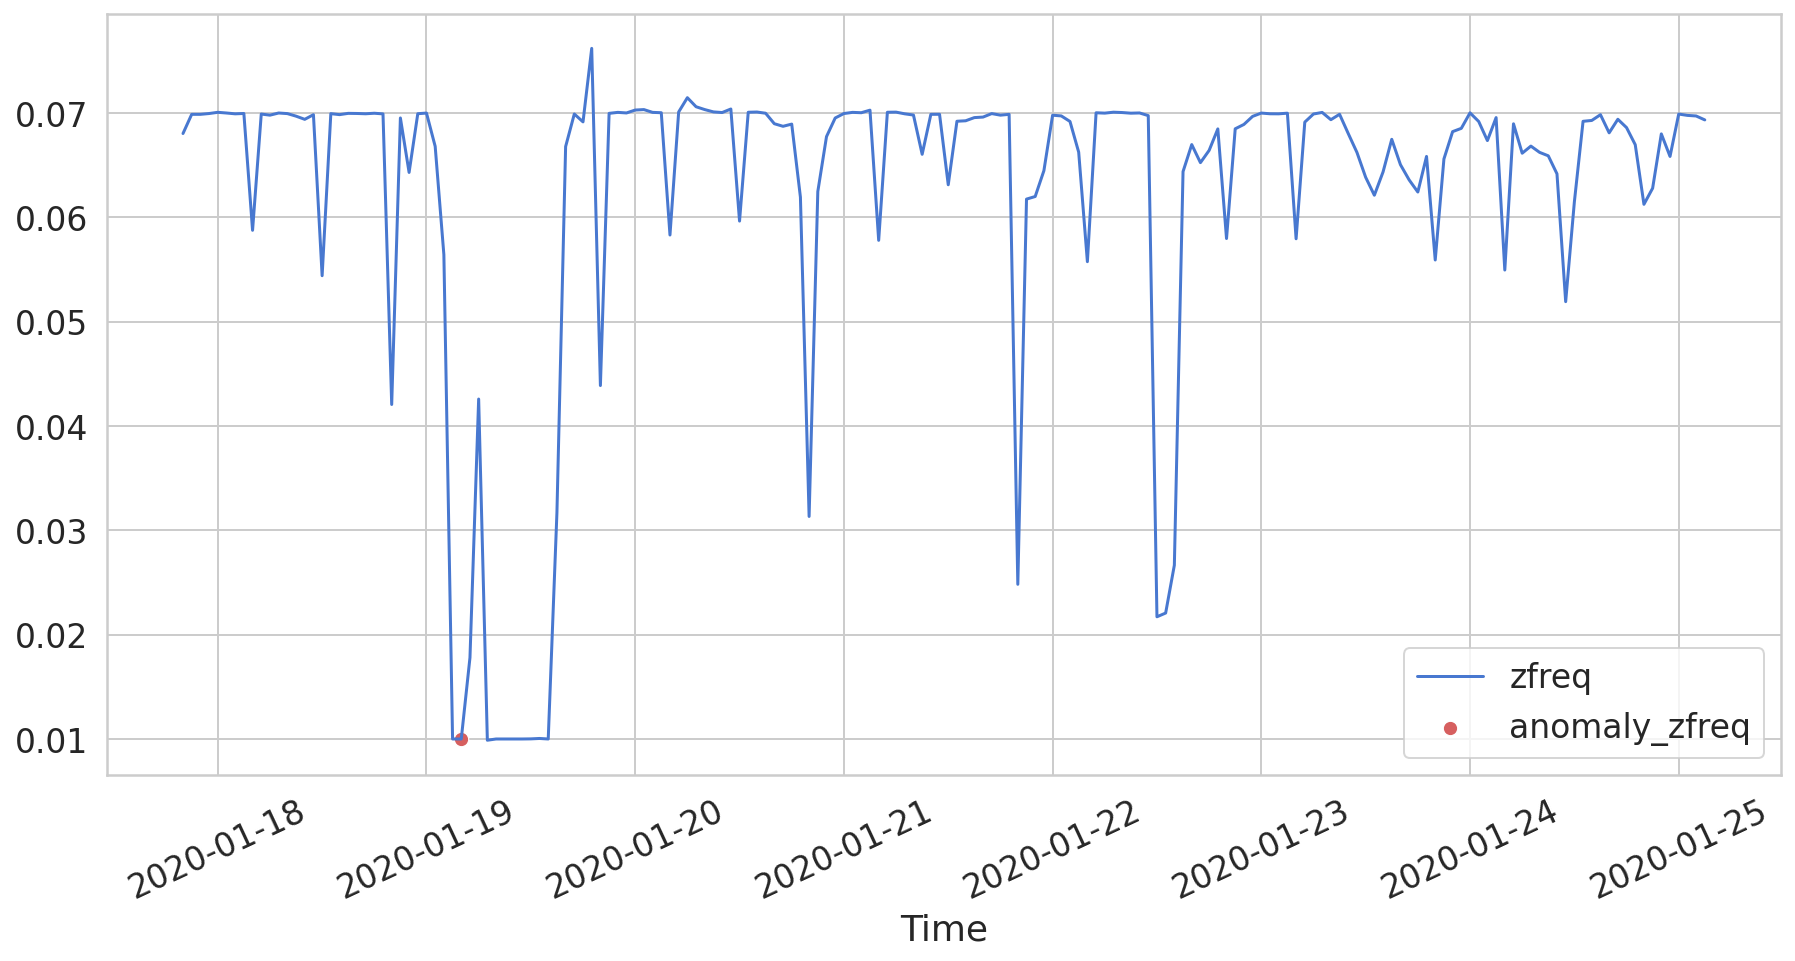

In [58]:
anomaly_plot(train,anomalies=anomalies_train)

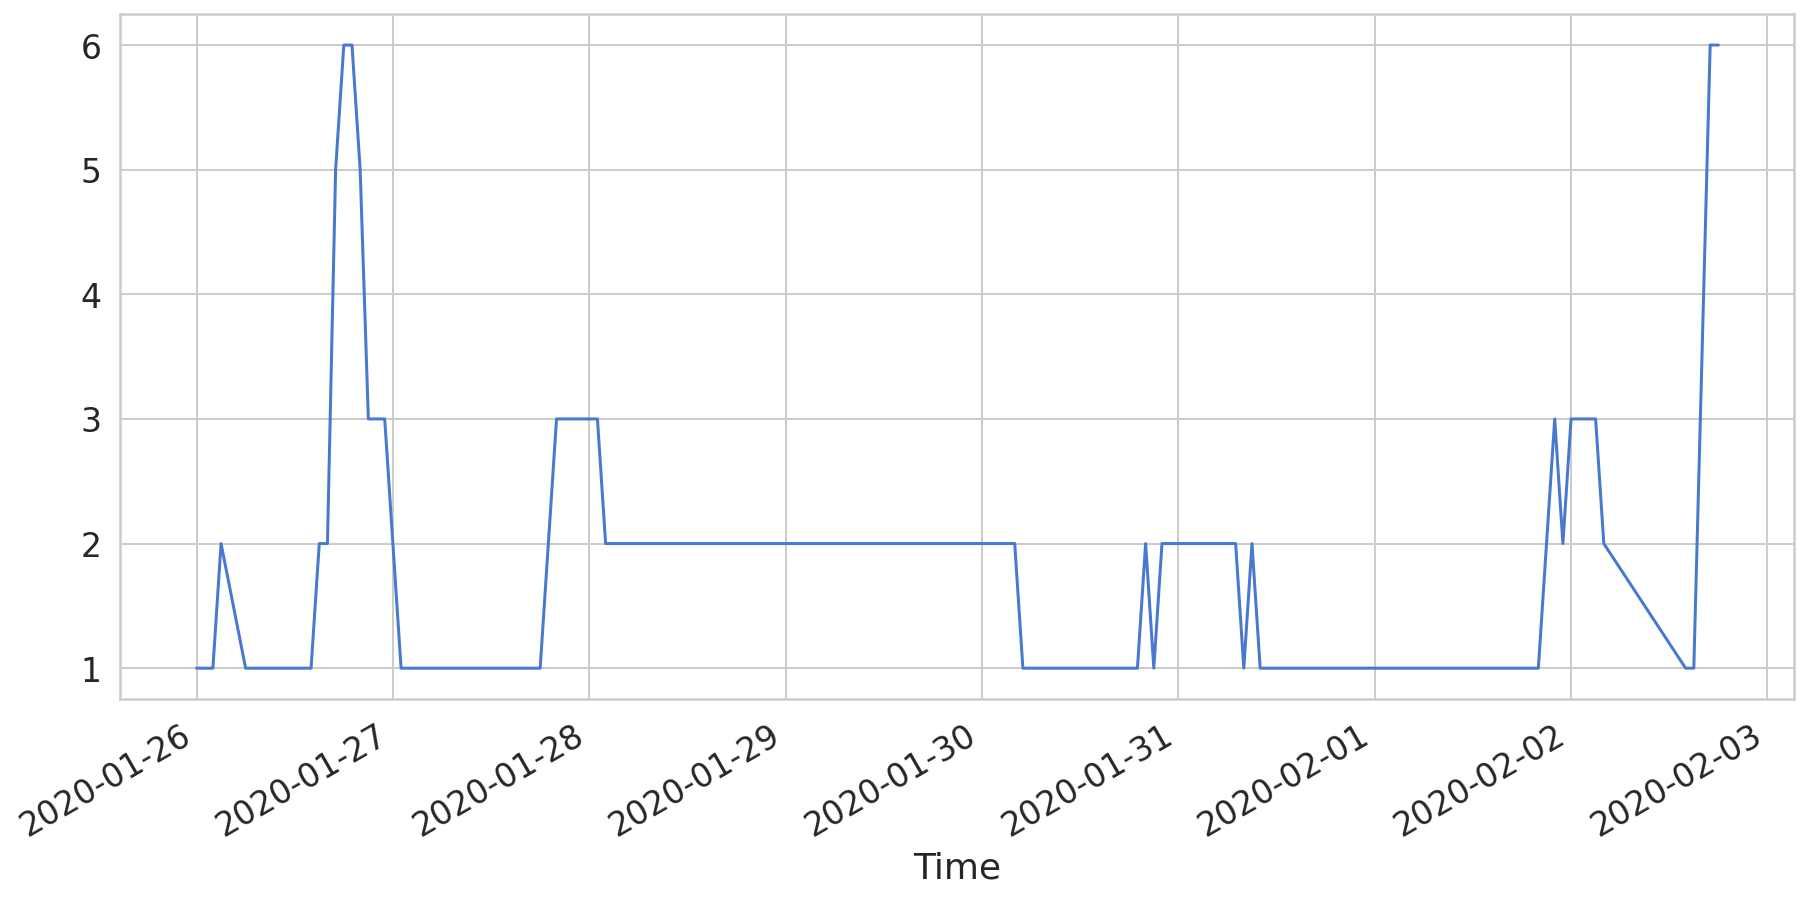

In [59]:
total_anomalies.groupby("Time")["anomaly_count"].sum().plot()

In [60]:
total_anomalies["Time"].value_counts()

2020-01-26 18:00:00    6
2020-01-26 19:00:00    6
2020-02-02 18:00:00    6
2020-02-02 17:00:00    6
2020-01-26 20:00:00    5
                      ..
2020-01-27 16:00:00    1
2020-02-01 10:00:00    1
2020-01-31 23:00:00    1
2020-01-31 12:00:00    1
2020-01-31 16:00:00    1
Name: Time, Length: 168, dtype: int64

In [61]:
total_anomalies.to_csv("total_anomaly.csv")